# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: min


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:27:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:27:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:27:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:27:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:28:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8278608500265529
Average Accuracy: 0.7528925619834711
Average Precision: 0.704433805819348
Average Recall: 0.6392833146696528


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:28:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:29:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8084186984094286
Average Accuracy: 0.7462535578340935
Average Precision: 0.7012702016473271
Average Recall: 0.6161478163493841


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66613


[1]	validation_0-logloss:0.66344


[2]	validation_0-logloss:0.66087


[3]	validation_0-logloss:0.65913


[4]	validation_0-logloss:0.65681


[5]	validation_0-logloss:0.65393


[6]	validation_0-logloss:0.65133


[7]	validation_0-logloss:0.64858


[8]	validation_0-logloss:0.64671


[9]	validation_0-logloss:0.64376


[10]	validation_0-logloss:0.64187


[11]	validation_0-logloss:0.63970


[12]	validation_0-logloss:0.63719


[13]	validation_0-logloss:0.63478


[14]	validation_0-logloss:0.63301


[15]	validation_0-logloss:0.63072


[16]	validation_0-logloss:0.62884


[17]	validation_0-logloss:0.62606


[18]	validation_0-logloss:0.62438


[19]	validation_0-logloss:0.62227


[20]	validation_0-logloss:0.62004


[21]	validation_0-logloss:0.61801


[22]	validation_0-logloss:0.61581


[23]	validation_0-logloss:0.61398


[24]	validation_0-logloss:0.61202


[25]	validation_0-logloss:0.61024


[26]	validation_0-logloss:0.60861


[27]	validation_0-logloss:0.60705


[28]	validation_0-logloss:0.60517


[29]	validation_0-logloss:0.60374


[30]	validation_0-logloss:0.60216


[31]	validation_0-logloss:0.60002


[32]	validation_0-logloss:0.59865


[33]	validation_0-logloss:0.59751


[34]	validation_0-logloss:0.59613


[35]	validation_0-logloss:0.59488


[36]	validation_0-logloss:0.59310


[37]	validation_0-logloss:0.59138


[38]	validation_0-logloss:0.58982


[39]	validation_0-logloss:0.58822


[40]	validation_0-logloss:0.58660


[41]	validation_0-logloss:0.58528


[42]	validation_0-logloss:0.58348


[43]	validation_0-logloss:0.58222


[44]	validation_0-logloss:0.58094


[45]	validation_0-logloss:0.57934


[46]	validation_0-logloss:0.57789


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation_0-logloss:0.57685


[48]	validation_0-logloss:0.57590


[49]	validation_0-logloss:0.57470


[50]	validation_0-logloss:0.57333


[51]	validation_0-logloss:0.57242


[52]	validation_0-logloss:0.57111


[53]	validation_0-logloss:0.56966


[54]	validation_0-logloss:0.56789


[55]	validation_0-logloss:0.56691


[56]	validation_0-logloss:0.56575


[57]	validation_0-logloss:0.56492


[58]	validation_0-logloss:0.56381


[59]	validation_0-logloss:0.56325

[60]	validation_0-logloss:0.56187


[61]	validation_0-logloss:0.56093


[62]	validation_0-logloss:0.55985


[63]	validation_0-logloss:0.55860


[64]	validation_0-logloss:0.55727


[65]	validation_0-logloss:0.55646


[66]	validation_0-logloss:0.55516


[67]	validation_0-logloss:0.55387


[68]	validation_0-logloss:0.55252


[69]	validation_0-logloss:0.55153


[70]	validation_0-logloss:0.55012


[71]	validation_0-logloss:0.54891


[72]	validation_0-logloss:0.54793


[73]	validation_0-logloss:0.54682


[74]	validation_0-logloss:0.54593


[75]	validation_0-logloss:0.54525


[76]	validation_0-logloss:0.54483


[77]	validation_0-logloss:0.54380


[78]	validation_0-logloss:0.54212


[79]	validation_0-logloss:0.54081

[80]	validation_0-logloss:0.53994


[81]	validation_0-logloss:0.53892


[82]	validation_0-logloss:0.53791


[83]	validation_0-logloss:0.53704


[84]	validation_0-logloss:0.53602


[85]	validation_0-logloss:0.53501


[86]	validation_0-logloss:0.53420


[87]	validation_0-logloss:0.53330


[88]	validation_0-logloss:0.53242


[89]	validation_0-logloss:0.53152


[90]	validation_0-logloss:0.53020


[91]	validation_0-logloss:0.52965


[92]	validation_0-logloss:0.52883


[93]	validation_0-logloss:0.52806


[94]	validation_0-logloss:0.52776


[95]	validation_0-logloss:0.52693


[96]	validation_0-logloss:0.52627


[97]	validation_0-logloss:0.52591


[98]	validation_0-logloss:0.52516


[99]	validation_0-logloss:0.52434


[100]	validation_0-logloss:0.52390


[101]	validation_0-logloss:0.52333

[102]	validation_0-logloss:0.52238


[103]	validation_0-logloss:0.52157


[104]	validation_0-logloss:0.52091


[105]	validation_0-logloss:0.52026


[106]	validation_0-logloss:0.51947


[107]	validation_0-logloss:0.51861


[108]	validation_0-logloss:0.51792


[109]	validation_0-logloss:0.51733


[110]	validation_0-logloss:0.51658


[111]	validation_0-logloss:0.51605


[112]	validation_0-logloss:0.51599


[113]	validation_0-logloss:0.51583


[114]	validation_0-logloss:0.51511


[115]	validation_0-logloss:0.51423


[116]	validation_0-logloss:0.51361


[117]	validation_0-logloss:0.51293


[118]	validation_0-logloss:0.51273


[119]	validation_0-logloss:0.51245


[120]	validation_0-logloss:0.51182


[121]	validation_0-logloss:0.51159


[122]	validation_0-logloss:0.51094


[123]	validation_0-logloss:0.51044


[124]	validation_0-logloss:0.51018


[125]	validation_0-logloss:0.50944


[126]	validation_0-logloss:0.50940

[127]	validation_0-logloss:0.50863


[128]	validation_0-logloss:0.50819


[129]	validation_0-logloss:0.50782


[130]	validation_0-logloss:0.50728

[131]	validation_0-logloss:0.50679


[132]	validation_0-logloss:0.50613


[133]	validation_0-logloss:0.50596


[134]	validation_0-logloss:0.50502


[135]	validation_0-logloss:0.50450


[136]	validation_0-logloss:0.50403


[137]	validation_0-logloss:0.50317


[138]	validation_0-logloss:0.50311


[139]	validation_0-logloss:0.50263


[140]	validation_0-logloss:0.50196


[141]	validation_0-logloss:0.50140


[142]	validation_0-logloss:0.50092


[143]	validation_0-logloss:0.50080


[144]	validation_0-logloss:0.50072


[145]	validation_0-logloss:0.50034


[146]	validation_0-logloss:0.49996


[147]	validation_0-logloss:0.49941


[148]	validation_0-logloss:0.49841


[149]	validation_0-logloss:0.49816


[150]	validation_0-logloss:0.49760


[151]	validation_0-logloss:0.49731

[152]	validation_0-logloss:0.49680


[153]	validation_0-logloss:0.49664


[154]	validation_0-logloss:0.49640


[155]	validation_0-logloss:0.49597


[156]	validation_0-logloss:0.49568

[157]	validation_0-logloss:0.49531


[158]	validation_0-logloss:0.49471


[159]	validation_0-logloss:0.49414


[160]	validation_0-logloss:0.49407


[161]	validation_0-logloss:0.49361


[162]	validation_0-logloss:0.49325


[163]	validation_0-logloss:0.49306


[164]	validation_0-logloss:0.49242


[165]	validation_0-logloss:0.49223


[166]	validation_0-logloss:0.49210


[167]	validation_0-logloss:0.49233


[168]	validation_0-logloss:0.49190


[169]	validation_0-logloss:0.49171


[170]	validation_0-logloss:0.49130


[171]	validation_0-logloss:0.49085


[172]	validation_0-logloss:0.49039


[173]	validation_0-logloss:0.49031


[174]	validation_0-logloss:0.48990


[175]	validation_0-logloss:0.48927


[176]	validation_0-logloss:0.48912


[177]	validation_0-logloss:0.48881


[178]	validation_0-logloss:0.48839


[179]	validation_0-logloss:0.48810


[180]	validation_0-logloss:0.48791


[181]	validation_0-logloss:0.48761


[182]	validation_0-logloss:0.48750


[183]	validation_0-logloss:0.48696


[184]	validation_0-logloss:0.48668


[185]	validation_0-logloss:0.48635


[186]	validation_0-logloss:0.48629


[187]	validation_0-logloss:0.48593


[188]	validation_0-logloss:0.48600


[189]	validation_0-logloss:0.48541


[190]	validation_0-logloss:0.48525


[191]	validation_0-logloss:0.48466


[192]	validation_0-logloss:0.48451


[193]	validation_0-logloss:0.48443


[194]	validation_0-logloss:0.48410


[195]	validation_0-logloss:0.48397


[196]	validation_0-logloss:0.48355


[197]	validation_0-logloss:0.48354


[198]	validation_0-logloss:0.48353


[199]	validation_0-logloss:0.48329

[200]	validation_0-logloss:0.48288


[201]	validation_0-logloss:0.48271


[202]	validation_0-logloss:0.48249


[203]	validation_0-logloss:0.48191


[204]	validation_0-logloss:0.48167


[205]	validation_0-logloss:0.48164


[206]	validation_0-logloss:0.48139


[207]	validation_0-logloss:0.48153


[208]	validation_0-logloss:0.48139


[209]	validation_0-logloss:0.48124


[210]	validation_0-logloss:0.48096


[211]	validation_0-logloss:0.48116


[212]	validation_0-logloss:0.48074


[213]	validation_0-logloss:0.48020


[214]	validation_0-logloss:0.48011


[215]	validation_0-logloss:0.48024


[216]	validation_0-logloss:0.47977


[217]	validation_0-logloss:0.47973


[218]	validation_0-logloss:0.47958


[219]	validation_0-logloss:0.47940

[220]	validation_0-logloss:0.47944


[221]	validation_0-logloss:0.47922


[222]	validation_0-logloss:0.47896

[223]	validation_0-logloss:0.47901


[224]	validation_0-logloss:0.47912


[225]	validation_0-logloss:0.47903


[226]	validation_0-logloss:0.47887


[227]	validation_0-logloss:0.47898


[228]	validation_0-logloss:0.47880


[229]	validation_0-logloss:0.47855


[230]	validation_0-logloss:0.47852


[231]	validation_0-logloss:0.47860


[232]	validation_0-logloss:0.47835


[233]	validation_0-logloss:0.47821


[234]	validation_0-logloss:0.47819


[235]	validation_0-logloss:0.47795


[236]	validation_0-logloss:0.47786


[237]	validation_0-logloss:0.47784


[238]	validation_0-logloss:0.47767


[239]	validation_0-logloss:0.47766


[240]	validation_0-logloss:0.47759


[241]	validation_0-logloss:0.47709


[242]	validation_0-logloss:0.47697


[243]	validation_0-logloss:0.47672


[244]	validation_0-logloss:0.47680


[245]	validation_0-logloss:0.47676


[246]	validation_0-logloss:0.47685


[247]	validation_0-logloss:0.47671


[248]	validation_0-logloss:0.47635


[249]	validation_0-logloss:0.47642


[250]	validation_0-logloss:0.47632


[251]	validation_0-logloss:0.47632


[252]	validation_0-logloss:0.47608


[253]	validation_0-logloss:0.47608


[254]	validation_0-logloss:0.47604


[255]	validation_0-logloss:0.47591


[256]	validation_0-logloss:0.47586


[257]	validation_0-logloss:0.47566


[258]	validation_0-logloss:0.47557


[259]	validation_0-logloss:0.47545


[260]	validation_0-logloss:0.47542


[261]	validation_0-logloss:0.47530


[262]	validation_0-logloss:0.47488


[263]	validation_0-logloss:0.47501


[264]	validation_0-logloss:0.47508


[265]	validation_0-logloss:0.47515


[266]	validation_0-logloss:0.47523


[267]	validation_0-logloss:0.47507


[268]	validation_0-logloss:0.47510


[269]	validation_0-logloss:0.47493


[270]	validation_0-logloss:0.47457


[271]	validation_0-logloss:0.47428


[272]	validation_0-logloss:0.47393


[273]	validation_0-logloss:0.47396


[274]	validation_0-logloss:0.47371


[275]	validation_0-logloss:0.47376


[276]	validation_0-logloss:0.47364


[277]	validation_0-logloss:0.47334


[278]	validation_0-logloss:0.47339


[279]	validation_0-logloss:0.47342


[280]	validation_0-logloss:0.47344


[281]	validation_0-logloss:0.47338


[282]	validation_0-logloss:0.47311


[283]	validation_0-logloss:0.47304


[284]	validation_0-logloss:0.47305


[285]	validation_0-logloss:0.47276


[286]	validation_0-logloss:0.47258


[287]	validation_0-logloss:0.47237


[288]	validation_0-logloss:0.47214


[289]	validation_0-logloss:0.47206


[290]	validation_0-logloss:0.47235


[291]	validation_0-logloss:0.47205


[292]	validation_0-logloss:0.47217


[293]	validation_0-logloss:0.47218


[294]	validation_0-logloss:0.47183


[295]	validation_0-logloss:0.47227


[296]	validation_0-logloss:0.47201


[297]	validation_0-logloss:0.47200


[298]	validation_0-logloss:0.47177

[299]	validation_0-logloss:0.47158


[300]	validation_0-logloss:0.47185


[301]	validation_0-logloss:0.47167


[302]	validation_0-logloss:0.47144


[303]	validation_0-logloss:0.47131


[304]	validation_0-logloss:0.47112


[305]	validation_0-logloss:0.47094


[306]	validation_0-logloss:0.47118


[307]	validation_0-logloss:0.47126


[308]	validation_0-logloss:0.47102

[309]	validation_0-logloss:0.47065

[310]	validation_0-logloss:0.47082


[311]	validation_0-logloss:0.47093

[312]	validation_0-logloss:0.47089


[313]	validation_0-logloss:0.47085


[314]	validation_0-logloss:0.47088


[315]	validation_0-logloss:0.47085


[316]	validation_0-logloss:0.47061

[317]	validation_0-logloss:0.47051


[318]	validation_0-logloss:0.47057


[319]	validation_0-logloss:0.47071


[320]	validation_0-logloss:0.47093


[321]	validation_0-logloss:0.47075


[322]	validation_0-logloss:0.47053


[323]	validation_0-logloss:0.47064


[324]	validation_0-logloss:0.47060


[325]	validation_0-logloss:0.47050


[326]	validation_0-logloss:0.47059


[327]	validation_0-logloss:0.47051


[328]	validation_0-logloss:0.47033


[329]	validation_0-logloss:0.47012


[330]	validation_0-logloss:0.47039


[331]	validation_0-logloss:0.47033


[332]	validation_0-logloss:0.47039


[333]	validation_0-logloss:0.47021


[334]	validation_0-logloss:0.47007


[335]	validation_0-logloss:0.46985


[336]	validation_0-logloss:0.47012


[337]	validation_0-logloss:0.47010


[338]	validation_0-logloss:0.47019


[339]	validation_0-logloss:0.47004


[340]	validation_0-logloss:0.47012


[341]	validation_0-logloss:0.47014

[342]	validation_0-logloss:0.47000


[343]	validation_0-logloss:0.46990


[344]	validation_0-logloss:0.46971


[345]	validation_0-logloss:0.47004

[346]	validation_0-logloss:0.46987


[347]	validation_0-logloss:0.47016


[348]	validation_0-logloss:0.47016


[349]	validation_0-logloss:0.46993


[350]	validation_0-logloss:0.46980


[351]	validation_0-logloss:0.46987


[352]	validation_0-logloss:0.47027


[353]	validation_0-logloss:0.47036


[0]	validation_0-logloss:0.66789


[1]	validation_0-logloss:0.66555


[2]	validation_0-logloss:0.66330


[3]	validation_0-logloss:0.66116


[4]	validation_0-logloss:0.65889


[5]	validation_0-logloss:0.65664


[6]	validation_0-logloss:0.65473


[7]	validation_0-logloss:0.65254


[8]	validation_0-logloss:0.65053


[9]	validation_0-logloss:0.64854


[10]	validation_0-logloss:0.64611


[11]	validation_0-logloss:0.64404


[12]	validation_0-logloss:0.64169


[13]	validation_0-logloss:0.63989


[14]	validation_0-logloss:0.63743


[15]	validation_0-logloss:0.63534


[16]	validation_0-logloss:0.63373


[17]	validation_0-logloss:0.63200


[18]	validation_0-logloss:0.62989


[19]	validation_0-logloss:0.62759


[20]	validation_0-logloss:0.62525


[21]	validation_0-logloss:0.62336


[22]	validation_0-logloss:0.62156


[23]	validation_0-logloss:0.61970


[24]	validation_0-logloss:0.61792


[25]	validation_0-logloss:0.61618


[26]	validation_0-logloss:0.61455


[27]	validation_0-logloss:0.61262


[28]	validation_0-logloss:0.61103


[29]	validation_0-logloss:0.61020


[30]	validation_0-logloss:0.60841


[31]	validation_0-logloss:0.60735


[32]	validation_0-logloss:0.60601


[33]	validation_0-logloss:0.60478


[34]	validation_0-logloss:0.60399


[35]	validation_0-logloss:0.60209


[36]	validation_0-logloss:0.60073


[37]	validation_0-logloss:0.59933


[38]	validation_0-logloss:0.59807


[39]	validation_0-logloss:0.59646


[40]	validation_0-logloss:0.59563


[41]	validation_0-logloss:0.59401


[42]	validation_0-logloss:0.59296


[43]	validation_0-logloss:0.59165


[44]	validation_0-logloss:0.59028


[45]	validation_0-logloss:0.58864


[46]	validation_0-logloss:0.58740


[47]	validation_0-logloss:0.58624


[48]	validation_0-logloss:0.58474


[49]	validation_0-logloss:0.58376


[50]	validation_0-logloss:0.58272


[51]	validation_0-logloss:0.58190


[52]	validation_0-logloss:0.58093


[53]	validation_0-logloss:0.57992


[54]	validation_0-logloss:0.57925


[55]	validation_0-logloss:0.57840


[56]	validation_0-logloss:0.57747


[57]	validation_0-logloss:0.57653


[58]	validation_0-logloss:0.57525


[59]	validation_0-logloss:0.57361


[60]	validation_0-logloss:0.57267


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:30:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[61]	validation_0-logloss:0.57155


[62]	validation_0-logloss:0.57037


[63]	validation_0-logloss:0.56971


[64]	validation_0-logloss:0.56915


[65]	validation_0-logloss:0.56754


[66]	validation_0-logloss:0.56637


[67]	validation_0-logloss:0.56511


[68]	validation_0-logloss:0.56377


[69]	validation_0-logloss:0.56249


[70]	validation_0-logloss:0.56194


[71]	validation_0-logloss:0.56111


[72]	validation_0-logloss:0.56044


[73]	validation_0-logloss:0.55933


[74]	validation_0-logloss:0.55859


[75]	validation_0-logloss:0.55756


[76]	validation_0-logloss:0.55715


[77]	validation_0-logloss:0.55623


[78]	validation_0-logloss:0.55557


[79]	validation_0-logloss:0.55478


[80]	validation_0-logloss:0.55407


[81]	validation_0-logloss:0.55314


[82]	validation_0-logloss:0.55198


[83]	validation_0-logloss:0.55115


[84]	validation_0-logloss:0.55050


[85]	validation_0-logloss:0.54974


[86]	validation_0-logloss:0.54902


[87]	validation_0-logloss:0.54852


[88]	validation_0-logloss:0.54762


[89]	validation_0-logloss:0.54713


[90]	validation_0-logloss:0.54629

[91]	validation_0-logloss:0.54554


[92]	validation_0-logloss:0.54497


[93]	validation_0-logloss:0.54445


[94]	validation_0-logloss:0.54336


[95]	validation_0-logloss:0.54281


[96]	validation_0-logloss:0.54227


[97]	validation_0-logloss:0.54203


[98]	validation_0-logloss:0.54163


[99]	validation_0-logloss:0.54100


[100]	validation_0-logloss:0.54038


[101]	validation_0-logloss:0.53965


[102]	validation_0-logloss:0.53884


[103]	validation_0-logloss:0.53785


[104]	validation_0-logloss:0.53703


[105]	validation_0-logloss:0.53641


[106]	validation_0-logloss:0.53591


[107]	validation_0-logloss:0.53551


[108]	validation_0-logloss:0.53511


[109]	validation_0-logloss:0.53474


[110]	validation_0-logloss:0.53476


[111]	validation_0-logloss:0.53379


[112]	validation_0-logloss:0.53321


[113]	validation_0-logloss:0.53294


[114]	validation_0-logloss:0.53242


[115]	validation_0-logloss:0.53199


[116]	validation_0-logloss:0.53183


[117]	validation_0-logloss:0.53117


[118]	validation_0-logloss:0.53036


[119]	validation_0-logloss:0.52984


[120]	validation_0-logloss:0.52951


[121]	validation_0-logloss:0.52905


[122]	validation_0-logloss:0.52844


[123]	validation_0-logloss:0.52786


[124]	validation_0-logloss:0.52729


[125]	validation_0-logloss:0.52683


[126]	validation_0-logloss:0.52584


[127]	validation_0-logloss:0.52566


[128]	validation_0-logloss:0.52538


[129]	validation_0-logloss:0.52515


[130]	validation_0-logloss:0.52477


[131]	validation_0-logloss:0.52441


[132]	validation_0-logloss:0.52380


[133]	validation_0-logloss:0.52361


[134]	validation_0-logloss:0.52287


[135]	validation_0-logloss:0.52272


[136]	validation_0-logloss:0.52219


[137]	validation_0-logloss:0.52190


[138]	validation_0-logloss:0.52155


[139]	validation_0-logloss:0.52140


[140]	validation_0-logloss:0.52127


[141]	validation_0-logloss:0.52094


[142]	validation_0-logloss:0.52056


[143]	validation_0-logloss:0.52035


[144]	validation_0-logloss:0.52020


[145]	validation_0-logloss:0.52005


[146]	validation_0-logloss:0.51959


[147]	validation_0-logloss:0.51948


[148]	validation_0-logloss:0.51921


[149]	validation_0-logloss:0.51883

[150]	validation_0-logloss:0.51819


[151]	validation_0-logloss:0.51799


[152]	validation_0-logloss:0.51792


[153]	validation_0-logloss:0.51792


[154]	validation_0-logloss:0.51745


[155]	validation_0-logloss:0.51741


[156]	validation_0-logloss:0.51724


[157]	validation_0-logloss:0.51686


[158]	validation_0-logloss:0.51688


[159]	validation_0-logloss:0.51650


[160]	validation_0-logloss:0.51634


[161]	validation_0-logloss:0.51653


[162]	validation_0-logloss:0.51664


[163]	validation_0-logloss:0.51592


[164]	validation_0-logloss:0.51532


[165]	validation_0-logloss:0.51475


[166]	validation_0-logloss:0.51444


[167]	validation_0-logloss:0.51386


[168]	validation_0-logloss:0.51359


[169]	validation_0-logloss:0.51358

[170]	validation_0-logloss:0.51335


[171]	validation_0-logloss:0.51319


[172]	validation_0-logloss:0.51304

[173]	validation_0-logloss:0.51262


[174]	validation_0-logloss:0.51261


[175]	validation_0-logloss:0.51227


[176]	validation_0-logloss:0.51200


[177]	validation_0-logloss:0.51196

[178]	validation_0-logloss:0.51171


[179]	validation_0-logloss:0.51143


[180]	validation_0-logloss:0.51119

[181]	validation_0-logloss:0.51081


[182]	validation_0-logloss:0.51049


[183]	validation_0-logloss:0.51027


[184]	validation_0-logloss:0.51023


[185]	validation_0-logloss:0.51011


[186]	validation_0-logloss:0.50995


[187]	validation_0-logloss:0.51006


[188]	validation_0-logloss:0.50963


[189]	validation_0-logloss:0.50959


[190]	validation_0-logloss:0.50942


[191]	validation_0-logloss:0.50907


[192]	validation_0-logloss:0.50867


[193]	validation_0-logloss:0.50855


[194]	validation_0-logloss:0.50870


[195]	validation_0-logloss:0.50872


[196]	validation_0-logloss:0.50848

[197]	validation_0-logloss:0.50826


[198]	validation_0-logloss:0.50810


[199]	validation_0-logloss:0.50771


[200]	validation_0-logloss:0.50761


[201]	validation_0-logloss:0.50723

[202]	validation_0-logloss:0.50676


[203]	validation_0-logloss:0.50645


[204]	validation_0-logloss:0.50655


[205]	validation_0-logloss:0.50630


[206]	validation_0-logloss:0.50624


[207]	validation_0-logloss:0.50600


[208]	validation_0-logloss:0.50587


[209]	validation_0-logloss:0.50583


[210]	validation_0-logloss:0.50538


[211]	validation_0-logloss:0.50532


[212]	validation_0-logloss:0.50533


[213]	validation_0-logloss:0.50513


[214]	validation_0-logloss:0.50508


[215]	validation_0-logloss:0.50471


[216]	validation_0-logloss:0.50458


[217]	validation_0-logloss:0.50446


[218]	validation_0-logloss:0.50441


[219]	validation_0-logloss:0.50441


[220]	validation_0-logloss:0.50398


[221]	validation_0-logloss:0.50390


[222]	validation_0-logloss:0.50363


[223]	validation_0-logloss:0.50365


[224]	validation_0-logloss:0.50355


[225]	validation_0-logloss:0.50318

[226]	validation_0-logloss:0.50326


[227]	validation_0-logloss:0.50312


[228]	validation_0-logloss:0.50320


[229]	validation_0-logloss:0.50322


[230]	validation_0-logloss:0.50333


[231]	validation_0-logloss:0.50331


[232]	validation_0-logloss:0.50321


[233]	validation_0-logloss:0.50324


[234]	validation_0-logloss:0.50305


[235]	validation_0-logloss:0.50286


[236]	validation_0-logloss:0.50290


[237]	validation_0-logloss:0.50293


[238]	validation_0-logloss:0.50273


[239]	validation_0-logloss:0.50248


[240]	validation_0-logloss:0.50264


[241]	validation_0-logloss:0.50238


[242]	validation_0-logloss:0.50243


[243]	validation_0-logloss:0.50269


[244]	validation_0-logloss:0.50258


[245]	validation_0-logloss:0.50259


[246]	validation_0-logloss:0.50254

[247]	validation_0-logloss:0.50255


[248]	validation_0-logloss:0.50280


[249]	validation_0-logloss:0.50302


[250]	validation_0-logloss:0.50233

[251]	validation_0-logloss:0.50241


[252]	validation_0-logloss:0.50254


[253]	validation_0-logloss:0.50196


[254]	validation_0-logloss:0.50169


[255]	validation_0-logloss:0.50147

[256]	validation_0-logloss:0.50118


[257]	validation_0-logloss:0.50087


[258]	validation_0-logloss:0.50062


[259]	validation_0-logloss:0.50048


[260]	validation_0-logloss:0.49995


[261]	validation_0-logloss:0.50002


[262]	validation_0-logloss:0.49979


[263]	validation_0-logloss:0.49962


[264]	validation_0-logloss:0.49943


[265]	validation_0-logloss:0.49941


[266]	validation_0-logloss:0.49925


[267]	validation_0-logloss:0.49939


[268]	validation_0-logloss:0.49950


[269]	validation_0-logloss:0.49977


[270]	validation_0-logloss:0.49983


[271]	validation_0-logloss:0.49951


[272]	validation_0-logloss:0.49949


[273]	validation_0-logloss:0.49951


[274]	validation_0-logloss:0.49905


[275]	validation_0-logloss:0.49898


[276]	validation_0-logloss:0.49891


[277]	validation_0-logloss:0.49944


[278]	validation_0-logloss:0.49954


[279]	validation_0-logloss:0.49947


[280]	validation_0-logloss:0.49929


[281]	validation_0-logloss:0.49905


[282]	validation_0-logloss:0.49929


[283]	validation_0-logloss:0.49895


[284]	validation_0-logloss:0.49858

[285]	validation_0-logloss:0.49891

[286]	validation_0-logloss:0.49906

[287]	validation_0-logloss:0.49900


[288]	validation_0-logloss:0.49906


[289]	validation_0-logloss:0.49906


[290]	validation_0-logloss:0.49896


[291]	validation_0-logloss:0.49860

[292]	validation_0-logloss:0.49854


[293]	validation_0-logloss:0.49851

[294]	validation_0-logloss:0.49831


[295]	validation_0-logloss:0.49857

[296]	validation_0-logloss:0.49863


[297]	validation_0-logloss:0.49838


[298]	validation_0-logloss:0.49847


[299]	validation_0-logloss:0.49867


[300]	validation_0-logloss:0.49863


[301]	validation_0-logloss:0.49880


[302]	validation_0-logloss:0.49885


[303]	validation_0-logloss:0.49875


[0]	validation_0-logloss:0.66833


[1]	validation_0-logloss:0.66568


[2]	validation_0-logloss:0.66358


[3]	validation_0-logloss:0.66164


[4]	validation_0-logloss:0.66028


[5]	validation_0-logloss:0.65838


[6]	validation_0-logloss:0.65651


[7]	validation_0-logloss:0.65390


[8]	validation_0-logloss:0.65257


[9]	validation_0-logloss:0.65057


[10]	validation_0-logloss:0.64882


[11]	validation_0-logloss:0.64683


[12]	validation_0-logloss:0.64488


[13]	validation_0-logloss:0.64335


[14]	validation_0-logloss:0.64154


[15]	validation_0-logloss:0.63986


[16]	validation_0-logloss:0.63879


[17]	validation_0-logloss:0.63712


[18]	validation_0-logloss:0.63612


[19]	validation_0-logloss:0.63454


[20]	validation_0-logloss:0.63312


[21]	validation_0-logloss:0.63131


[22]	validation_0-logloss:0.62995


[23]	validation_0-logloss:0.62891


[24]	validation_0-logloss:0.62720


[25]	validation_0-logloss:0.62605


[26]	validation_0-logloss:0.62466


[27]	validation_0-logloss:0.62404


[28]	validation_0-logloss:0.62298


[29]	validation_0-logloss:0.62219


[30]	validation_0-logloss:0.62060


[31]	validation_0-logloss:0.61962


[32]	validation_0-logloss:0.61900


[33]	validation_0-logloss:0.61726


[34]	validation_0-logloss:0.61611


[35]	validation_0-logloss:0.61530


[36]	validation_0-logloss:0.61417


[37]	validation_0-logloss:0.61374


[38]	validation_0-logloss:0.61279


[39]	validation_0-logloss:0.61189


[40]	validation_0-logloss:0.61064


[41]	validation_0-logloss:0.60913


[42]	validation_0-logloss:0.60852


[43]	validation_0-logloss:0.60697


[44]	validation_0-logloss:0.60561


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation_0-logloss:0.60438


[46]	validation_0-logloss:0.60313


[47]	validation_0-logloss:0.60191


[48]	validation_0-logloss:0.60076


[49]	validation_0-logloss:0.59929


[50]	validation_0-logloss:0.59794


[51]	validation_0-logloss:0.59678


[52]	validation_0-logloss:0.59573

[53]	validation_0-logloss:0.59494


[54]	validation_0-logloss:0.59436


[55]	validation_0-logloss:0.59341


[56]	validation_0-logloss:0.59211


[57]	validation_0-logloss:0.59083


[58]	validation_0-logloss:0.58985


[59]	validation_0-logloss:0.58837


[60]	validation_0-logloss:0.58725


[61]	validation_0-logloss:0.58612


[62]	validation_0-logloss:0.58530


[63]	validation_0-logloss:0.58418


[64]	validation_0-logloss:0.58371


[65]	validation_0-logloss:0.58279


[66]	validation_0-logloss:0.58221


[67]	validation_0-logloss:0.58130


[68]	validation_0-logloss:0.58093


[69]	validation_0-logloss:0.57981


[70]	validation_0-logloss:0.57883


[71]	validation_0-logloss:0.57837


[72]	validation_0-logloss:0.57729


[73]	validation_0-logloss:0.57608


[74]	validation_0-logloss:0.57579


[75]	validation_0-logloss:0.57515


[76]	validation_0-logloss:0.57456


[77]	validation_0-logloss:0.57413


[78]	validation_0-logloss:0.57363


[79]	validation_0-logloss:0.57312


[80]	validation_0-logloss:0.57277


[81]	validation_0-logloss:0.57238


[82]	validation_0-logloss:0.57161


[83]	validation_0-logloss:0.57108


[84]	validation_0-logloss:0.56996


[85]	validation_0-logloss:0.56944


[86]	validation_0-logloss:0.56913


[87]	validation_0-logloss:0.56858


[88]	validation_0-logloss:0.56756


[89]	validation_0-logloss:0.56744


[90]	validation_0-logloss:0.56694


[91]	validation_0-logloss:0.56633


[92]	validation_0-logloss:0.56577


[93]	validation_0-logloss:0.56535


[94]	validation_0-logloss:0.56474


[95]	validation_0-logloss:0.56464


[96]	validation_0-logloss:0.56376


[97]	validation_0-logloss:0.56377


[98]	validation_0-logloss:0.56327

[99]	validation_0-logloss:0.56344


[100]	validation_0-logloss:0.56321


[101]	validation_0-logloss:0.56297


[102]	validation_0-logloss:0.56269


[103]	validation_0-logloss:0.56166


[104]	validation_0-logloss:0.56098


[105]	validation_0-logloss:0.56105


[106]	validation_0-logloss:0.56074


[107]	validation_0-logloss:0.56009


[108]	validation_0-logloss:0.55976


[109]	validation_0-logloss:0.55919


[110]	validation_0-logloss:0.55854


[111]	validation_0-logloss:0.55797


[112]	validation_0-logloss:0.55750


[113]	validation_0-logloss:0.55721

[114]	validation_0-logloss:0.55682


[115]	validation_0-logloss:0.55605


[116]	validation_0-logloss:0.55523


[117]	validation_0-logloss:0.55476


[118]	validation_0-logloss:0.55414


[119]	validation_0-logloss:0.55394


[120]	validation_0-logloss:0.55344


[121]	validation_0-logloss:0.55307


[122]	validation_0-logloss:0.55253


[123]	validation_0-logloss:0.55168


[124]	validation_0-logloss:0.55085


[125]	validation_0-logloss:0.55049


[126]	validation_0-logloss:0.55039


[127]	validation_0-logloss:0.54996


[128]	validation_0-logloss:0.54922


[129]	validation_0-logloss:0.54899


[130]	validation_0-logloss:0.54915

[131]	validation_0-logloss:0.54849


[132]	validation_0-logloss:0.54848


[133]	validation_0-logloss:0.54827


[134]	validation_0-logloss:0.54835

[135]	validation_0-logloss:0.54823


[136]	validation_0-logloss:0.54782


[137]	validation_0-logloss:0.54754


[138]	validation_0-logloss:0.54718


[139]	validation_0-logloss:0.54691


[140]	validation_0-logloss:0.54646

[141]	validation_0-logloss:0.54630


[142]	validation_0-logloss:0.54576

[143]	validation_0-logloss:0.54576


[144]	validation_0-logloss:0.54602


[145]	validation_0-logloss:0.54581


[146]	validation_0-logloss:0.54526


[147]	validation_0-logloss:0.54504


[148]	validation_0-logloss:0.54496


[149]	validation_0-logloss:0.54491


[150]	validation_0-logloss:0.54486


[151]	validation_0-logloss:0.54433


[152]	validation_0-logloss:0.54414


[153]	validation_0-logloss:0.54420


[154]	validation_0-logloss:0.54401


[155]	validation_0-logloss:0.54328


[156]	validation_0-logloss:0.54321


[157]	validation_0-logloss:0.54271


[158]	validation_0-logloss:0.54200


[159]	validation_0-logloss:0.54210


[160]	validation_0-logloss:0.54207


[161]	validation_0-logloss:0.54170


[162]	validation_0-logloss:0.54145


[163]	validation_0-logloss:0.54136


[164]	validation_0-logloss:0.54105


[165]	validation_0-logloss:0.54097


[166]	validation_0-logloss:0.54037


[167]	validation_0-logloss:0.53979


[168]	validation_0-logloss:0.53940


[169]	validation_0-logloss:0.53888


[170]	validation_0-logloss:0.53872


[171]	validation_0-logloss:0.53861


[172]	validation_0-logloss:0.53814


[173]	validation_0-logloss:0.53732


[174]	validation_0-logloss:0.53725


[175]	validation_0-logloss:0.53687


[176]	validation_0-logloss:0.53681


[177]	validation_0-logloss:0.53629


[178]	validation_0-logloss:0.53609


[179]	validation_0-logloss:0.53575


[180]	validation_0-logloss:0.53551


[181]	validation_0-logloss:0.53538


[182]	validation_0-logloss:0.53518


[183]	validation_0-logloss:0.53511


[184]	validation_0-logloss:0.53491


[185]	validation_0-logloss:0.53505


[186]	validation_0-logloss:0.53491


[187]	validation_0-logloss:0.53494


[188]	validation_0-logloss:0.53476


[189]	validation_0-logloss:0.53474


[190]	validation_0-logloss:0.53447


[191]	validation_0-logloss:0.53448


[192]	validation_0-logloss:0.53460


[193]	validation_0-logloss:0.53423


[194]	validation_0-logloss:0.53395


[195]	validation_0-logloss:0.53384


[196]	validation_0-logloss:0.53389


[197]	validation_0-logloss:0.53376


[198]	validation_0-logloss:0.53410


[199]	validation_0-logloss:0.53419


[200]	validation_0-logloss:0.53410


[201]	validation_0-logloss:0.53411


[202]	validation_0-logloss:0.53378


[203]	validation_0-logloss:0.53342


[204]	validation_0-logloss:0.53331


[205]	validation_0-logloss:0.53284


[206]	validation_0-logloss:0.53269


[207]	validation_0-logloss:0.53236

[208]	validation_0-logloss:0.53233


[209]	validation_0-logloss:0.53200

[210]	validation_0-logloss:0.53230

[211]	validation_0-logloss:0.53180


[212]	validation_0-logloss:0.53160


[213]	validation_0-logloss:0.53118


[214]	validation_0-logloss:0.53091


[215]	validation_0-logloss:0.53065


[216]	validation_0-logloss:0.53054


[217]	validation_0-logloss:0.53063


[218]	validation_0-logloss:0.53060


[219]	validation_0-logloss:0.53020


[220]	validation_0-logloss:0.53006


[221]	validation_0-logloss:0.52975


[222]	validation_0-logloss:0.52988


[223]	validation_0-logloss:0.52947


[224]	validation_0-logloss:0.52961


[225]	validation_0-logloss:0.52970


[226]	validation_0-logloss:0.52948


[227]	validation_0-logloss:0.52936


[228]	validation_0-logloss:0.52937

[229]	validation_0-logloss:0.52947


[230]	validation_0-logloss:0.52948


[231]	validation_0-logloss:0.52928


[232]	validation_0-logloss:0.52917


[233]	validation_0-logloss:0.52901


[234]	validation_0-logloss:0.52890

[235]	validation_0-logloss:0.52899


[236]	validation_0-logloss:0.52894


[237]	validation_0-logloss:0.52872


[238]	validation_0-logloss:0.52839


[239]	validation_0-logloss:0.52822


[240]	validation_0-logloss:0.52835


[241]	validation_0-logloss:0.52874


[242]	validation_0-logloss:0.52845


[243]	validation_0-logloss:0.52844


[244]	validation_0-logloss:0.52866


[245]	validation_0-logloss:0.52882


[246]	validation_0-logloss:0.52921


[247]	validation_0-logloss:0.52890


[248]	validation_0-logloss:0.52910


[249]	validation_0-logloss:0.52925


[0]	validation_0-logloss:0.66853


[1]	validation_0-logloss:0.66598


[2]	validation_0-logloss:0.66333


[3]	validation_0-logloss:0.66162


[4]	validation_0-logloss:0.65923


[5]	validation_0-logloss:0.65717


[6]	validation_0-logloss:0.65543


[7]	validation_0-logloss:0.65324


[8]	validation_0-logloss:0.65112


[9]	validation_0-logloss:0.64990


[10]	validation_0-logloss:0.64789


[11]	validation_0-logloss:0.64587


[12]	validation_0-logloss:0.64360


[13]	validation_0-logloss:0.64096


[14]	validation_0-logloss:0.63937


[15]	validation_0-logloss:0.63709


[16]	validation_0-logloss:0.63483


[17]	validation_0-logloss:0.63327


[18]	validation_0-logloss:0.63159


[19]	validation_0-logloss:0.63000


[20]	validation_0-logloss:0.62817


[21]	validation_0-logloss:0.62684


[22]	validation_0-logloss:0.62580


[23]	validation_0-logloss:0.62456


[24]	validation_0-logloss:0.62264


[25]	validation_0-logloss:0.62119


[26]	validation_0-logloss:0.61957


[27]	validation_0-logloss:0.61731


[28]	validation_0-logloss:0.61549


[29]	validation_0-logloss:0.61356


[30]	validation_0-logloss:0.61214


[31]	validation_0-logloss:0.61102


[32]	validation_0-logloss:0.60946


[33]	validation_0-logloss:0.60814


[34]	validation_0-logloss:0.60684


[35]	validation_0-logloss:0.60569


[36]	validation_0-logloss:0.60397


[37]	validation_0-logloss:0.60302


[38]	validation_0-logloss:0.60222


[39]	validation_0-logloss:0.60030


[40]	validation_0-logloss:0.59913


[41]	validation_0-logloss:0.59793


[42]	validation_0-logloss:0.59688


[43]	validation_0-logloss:0.59578


[44]	validation_0-logloss:0.59465


[45]	validation_0-logloss:0.59342


[46]	validation_0-logloss:0.59227


[47]	validation_0-logloss:0.59120


[48]	validation_0-logloss:0.59016


[49]	validation_0-logloss:0.58885


[50]	validation_0-logloss:0.58778


[51]	validation_0-logloss:0.58654


[52]	validation_0-logloss:0.58548


[53]	validation_0-logloss:0.58464


[54]	validation_0-logloss:0.58363


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation_0-logloss:0.58254


[56]	validation_0-logloss:0.58162


[57]	validation_0-logloss:0.58079


[58]	validation_0-logloss:0.57966


[59]	validation_0-logloss:0.57835


[60]	validation_0-logloss:0.57686


[61]	validation_0-logloss:0.57566


[62]	validation_0-logloss:0.57465


[63]	validation_0-logloss:0.57352


[64]	validation_0-logloss:0.57198

[65]	validation_0-logloss:0.57051


[66]	validation_0-logloss:0.56967


[67]	validation_0-logloss:0.56891


[68]	validation_0-logloss:0.56812


[69]	validation_0-logloss:0.56768

[70]	validation_0-logloss:0.56675


[71]	validation_0-logloss:0.56593

[72]	validation_0-logloss:0.56510


[73]	validation_0-logloss:0.56422


[74]	validation_0-logloss:0.56328

[75]	validation_0-logloss:0.56295

[76]	validation_0-logloss:0.56212


[77]	validation_0-logloss:0.56161


[78]	validation_0-logloss:0.56020


[79]	validation_0-logloss:0.55935


[80]	validation_0-logloss:0.55858

[81]	validation_0-logloss:0.55771

[82]	validation_0-logloss:0.55731


[83]	validation_0-logloss:0.55654


[84]	validation_0-logloss:0.55608


[85]	validation_0-logloss:0.55464


[86]	validation_0-logloss:0.55408


[87]	validation_0-logloss:0.55330


[88]	validation_0-logloss:0.55216

[89]	validation_0-logloss:0.55106


[90]	validation_0-logloss:0.55063


[91]	validation_0-logloss:0.54987


[92]	validation_0-logloss:0.54949


[93]	validation_0-logloss:0.54875


[94]	validation_0-logloss:0.54821


[95]	validation_0-logloss:0.54750


[96]	validation_0-logloss:0.54670


[97]	validation_0-logloss:0.54561


[98]	validation_0-logloss:0.54495


[99]	validation_0-logloss:0.54444


[100]	validation_0-logloss:0.54407


[101]	validation_0-logloss:0.54368


[102]	validation_0-logloss:0.54286


[103]	validation_0-logloss:0.54244


[104]	validation_0-logloss:0.54171


[105]	validation_0-logloss:0.54127


[106]	validation_0-logloss:0.54037


[107]	validation_0-logloss:0.54030


[108]	validation_0-logloss:0.53934


[109]	validation_0-logloss:0.53881


[110]	validation_0-logloss:0.53859


[111]	validation_0-logloss:0.53776


[112]	validation_0-logloss:0.53737


[113]	validation_0-logloss:0.53692


[114]	validation_0-logloss:0.53615


[115]	validation_0-logloss:0.53602


[116]	validation_0-logloss:0.53525


[117]	validation_0-logloss:0.53508


[118]	validation_0-logloss:0.53433


[119]	validation_0-logloss:0.53374


[120]	validation_0-logloss:0.53272


[121]	validation_0-logloss:0.53241


[122]	validation_0-logloss:0.53149


[123]	validation_0-logloss:0.53089


[124]	validation_0-logloss:0.53062


[125]	validation_0-logloss:0.53026


[126]	validation_0-logloss:0.52989


[127]	validation_0-logloss:0.52919


[128]	validation_0-logloss:0.52855


[129]	validation_0-logloss:0.52838


[130]	validation_0-logloss:0.52774


[131]	validation_0-logloss:0.52727


[132]	validation_0-logloss:0.52705


[133]	validation_0-logloss:0.52623


[134]	validation_0-logloss:0.52622


[135]	validation_0-logloss:0.52545


[136]	validation_0-logloss:0.52510


[137]	validation_0-logloss:0.52462


[138]	validation_0-logloss:0.52378


[139]	validation_0-logloss:0.52342


[140]	validation_0-logloss:0.52284


[141]	validation_0-logloss:0.52236


[142]	validation_0-logloss:0.52225


[143]	validation_0-logloss:0.52145


[144]	validation_0-logloss:0.52077

[145]	validation_0-logloss:0.52027


[146]	validation_0-logloss:0.51943


[147]	validation_0-logloss:0.51904


[148]	validation_0-logloss:0.51860

[149]	validation_0-logloss:0.51801


[150]	validation_0-logloss:0.51747


[151]	validation_0-logloss:0.51709


[152]	validation_0-logloss:0.51653


[153]	validation_0-logloss:0.51629


[154]	validation_0-logloss:0.51576


[155]	validation_0-logloss:0.51568


[156]	validation_0-logloss:0.51559


[157]	validation_0-logloss:0.51517


[158]	validation_0-logloss:0.51458

[159]	validation_0-logloss:0.51429

[160]	validation_0-logloss:0.51397


[161]	validation_0-logloss:0.51362


[162]	validation_0-logloss:0.51282


[163]	validation_0-logloss:0.51261


[164]	validation_0-logloss:0.51210

[165]	validation_0-logloss:0.51235


[166]	validation_0-logloss:0.51202


[167]	validation_0-logloss:0.51137


[168]	validation_0-logloss:0.51142

[169]	validation_0-logloss:0.51153


[170]	validation_0-logloss:0.51101


[171]	validation_0-logloss:0.51080


[172]	validation_0-logloss:0.51051

[173]	validation_0-logloss:0.51019


[174]	validation_0-logloss:0.51012


[175]	validation_0-logloss:0.50953


[176]	validation_0-logloss:0.50903


[177]	validation_0-logloss:0.50884


[178]	validation_0-logloss:0.50851


[179]	validation_0-logloss:0.50848


[180]	validation_0-logloss:0.50827


[181]	validation_0-logloss:0.50783


[182]	validation_0-logloss:0.50740


[183]	validation_0-logloss:0.50715


[184]	validation_0-logloss:0.50686


[185]	validation_0-logloss:0.50667


[186]	validation_0-logloss:0.50652


[187]	validation_0-logloss:0.50611


[188]	validation_0-logloss:0.50583


[189]	validation_0-logloss:0.50534


[190]	validation_0-logloss:0.50502


[191]	validation_0-logloss:0.50477


[192]	validation_0-logloss:0.50424


[193]	validation_0-logloss:0.50411


[194]	validation_0-logloss:0.50385


[195]	validation_0-logloss:0.50303


[196]	validation_0-logloss:0.50287


[197]	validation_0-logloss:0.50277


[198]	validation_0-logloss:0.50269


[199]	validation_0-logloss:0.50263


[200]	validation_0-logloss:0.50276

[201]	validation_0-logloss:0.50292


[202]	validation_0-logloss:0.50257


[203]	validation_0-logloss:0.50246


[204]	validation_0-logloss:0.50202

[205]	validation_0-logloss:0.50158

[206]	validation_0-logloss:0.50157


[207]	validation_0-logloss:0.50172

[208]	validation_0-logloss:0.50178


[209]	validation_0-logloss:0.50130


[210]	validation_0-logloss:0.50141


[211]	validation_0-logloss:0.50118


[212]	validation_0-logloss:0.50100


[213]	validation_0-logloss:0.50040


[214]	validation_0-logloss:0.50002

[215]	validation_0-logloss:0.49938

[216]	validation_0-logloss:0.49938


[217]	validation_0-logloss:0.49883


[218]	validation_0-logloss:0.49866


[219]	validation_0-logloss:0.49866


[220]	validation_0-logloss:0.49894


[221]	validation_0-logloss:0.49900


[222]	validation_0-logloss:0.49907


[223]	validation_0-logloss:0.49890


[224]	validation_0-logloss:0.49894


[225]	validation_0-logloss:0.49900


[226]	validation_0-logloss:0.49903

[227]	validation_0-logloss:0.49827


[228]	validation_0-logloss:0.49766


[229]	validation_0-logloss:0.49760


[230]	validation_0-logloss:0.49755


[231]	validation_0-logloss:0.49750


[232]	validation_0-logloss:0.49686


[233]	validation_0-logloss:0.49685


[234]	validation_0-logloss:0.49674


[235]	validation_0-logloss:0.49675


[236]	validation_0-logloss:0.49684


[237]	validation_0-logloss:0.49678


[238]	validation_0-logloss:0.49672


[239]	validation_0-logloss:0.49670


[240]	validation_0-logloss:0.49646


[241]	validation_0-logloss:0.49622


[242]	validation_0-logloss:0.49611


[243]	validation_0-logloss:0.49631


[244]	validation_0-logloss:0.49597


[245]	validation_0-logloss:0.49592


[246]	validation_0-logloss:0.49562


[247]	validation_0-logloss:0.49563


[248]	validation_0-logloss:0.49566


[249]	validation_0-logloss:0.49553


[250]	validation_0-logloss:0.49548


[251]	validation_0-logloss:0.49548


[252]	validation_0-logloss:0.49565


[253]	validation_0-logloss:0.49531


[254]	validation_0-logloss:0.49526


[255]	validation_0-logloss:0.49534


[256]	validation_0-logloss:0.49497


[257]	validation_0-logloss:0.49503


[258]	validation_0-logloss:0.49521


[259]	validation_0-logloss:0.49517

[260]	validation_0-logloss:0.49539


[261]	validation_0-logloss:0.49523


[262]	validation_0-logloss:0.49531


[263]	validation_0-logloss:0.49536


[264]	validation_0-logloss:0.49540


[265]	validation_0-logloss:0.49534


[0]	validation_0-logloss:0.66847


[1]	validation_0-logloss:0.66543


[2]	validation_0-logloss:0.66295


[3]	validation_0-logloss:0.66084


[4]	validation_0-logloss:0.65889


[5]	validation_0-logloss:0.65740


[6]	validation_0-logloss:0.65534


[7]	validation_0-logloss:0.65331


[8]	validation_0-logloss:0.65164


[9]	validation_0-logloss:0.64955


[10]	validation_0-logloss:0.64739


[11]	validation_0-logloss:0.64614


[12]	validation_0-logloss:0.64372


[13]	validation_0-logloss:0.64105


[14]	validation_0-logloss:0.63884


[15]	validation_0-logloss:0.63650


[16]	validation_0-logloss:0.63467


[17]	validation_0-logloss:0.63332


[18]	validation_0-logloss:0.63169


[19]	validation_0-logloss:0.62989


[20]	validation_0-logloss:0.62829


[21]	validation_0-logloss:0.62584


[22]	validation_0-logloss:0.62407


[23]	validation_0-logloss:0.62243


[24]	validation_0-logloss:0.62084


[25]	validation_0-logloss:0.61902


[26]	validation_0-logloss:0.61780


[27]	validation_0-logloss:0.61596


[28]	validation_0-logloss:0.61464


[29]	validation_0-logloss:0.61328


[30]	validation_0-logloss:0.61168


[31]	validation_0-logloss:0.61018


[32]	validation_0-logloss:0.60862


[33]	validation_0-logloss:0.60668


[34]	validation_0-logloss:0.60467


[35]	validation_0-logloss:0.60353


[36]	validation_0-logloss:0.60204


[37]	validation_0-logloss:0.60067


[38]	validation_0-logloss:0.59933


[39]	validation_0-logloss:0.59808


[40]	validation_0-logloss:0.59640


[41]	validation_0-logloss:0.59538


[42]	validation_0-logloss:0.59394


[43]	validation_0-logloss:0.59282


[44]	validation_0-logloss:0.59179


[45]	validation_0-logloss:0.59080


[46]	validation_0-logloss:0.58933


[47]	validation_0-logloss:0.58807


[48]	validation_0-logloss:0.58745


[49]	validation_0-logloss:0.58663


[50]	validation_0-logloss:0.58547


[51]	validation_0-logloss:0.58432


[52]	validation_0-logloss:0.58348


[53]	validation_0-logloss:0.58292


[54]	validation_0-logloss:0.58183


[55]	validation_0-logloss:0.58076


[56]	validation_0-logloss:0.58012


[57]	validation_0-logloss:0.57873


[58]	validation_0-logloss:0.57741


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation_0-logloss:0.57627


[60]	validation_0-logloss:0.57533


[61]	validation_0-logloss:0.57414


[62]	validation_0-logloss:0.57311


[63]	validation_0-logloss:0.57154


[64]	validation_0-logloss:0.57082

[65]	validation_0-logloss:0.56984


[66]	validation_0-logloss:0.56892


[67]	validation_0-logloss:0.56836


[68]	validation_0-logloss:0.56782


[69]	validation_0-logloss:0.56679


[70]	validation_0-logloss:0.56569


[71]	validation_0-logloss:0.56519


[72]	validation_0-logloss:0.56438


[73]	validation_0-logloss:0.56392


[74]	validation_0-logloss:0.56298


[75]	validation_0-logloss:0.56215


[76]	validation_0-logloss:0.56114


[77]	validation_0-logloss:0.56069


[78]	validation_0-logloss:0.55931


[79]	validation_0-logloss:0.55834


[80]	validation_0-logloss:0.55726


[81]	validation_0-logloss:0.55661


[82]	validation_0-logloss:0.55629


[83]	validation_0-logloss:0.55580


[84]	validation_0-logloss:0.55493


[85]	validation_0-logloss:0.55441


[86]	validation_0-logloss:0.55371


[87]	validation_0-logloss:0.55307


[88]	validation_0-logloss:0.55267


[89]	validation_0-logloss:0.55177


[90]	validation_0-logloss:0.55100


[91]	validation_0-logloss:0.55041


[92]	validation_0-logloss:0.54968


[93]	validation_0-logloss:0.54876


[94]	validation_0-logloss:0.54830


[95]	validation_0-logloss:0.54751


[96]	validation_0-logloss:0.54675


[97]	validation_0-logloss:0.54598


[98]	validation_0-logloss:0.54549


[99]	validation_0-logloss:0.54471


[100]	validation_0-logloss:0.54476


[101]	validation_0-logloss:0.54445

[102]	validation_0-logloss:0.54426


[103]	validation_0-logloss:0.54357


[104]	validation_0-logloss:0.54296


[105]	validation_0-logloss:0.54200


[106]	validation_0-logloss:0.54169


[107]	validation_0-logloss:0.54148


[108]	validation_0-logloss:0.54072


[109]	validation_0-logloss:0.54001


[110]	validation_0-logloss:0.53945


[111]	validation_0-logloss:0.53920


[112]	validation_0-logloss:0.53869


[113]	validation_0-logloss:0.53819


[114]	validation_0-logloss:0.53726


[115]	validation_0-logloss:0.53736


[116]	validation_0-logloss:0.53640


[117]	validation_0-logloss:0.53597


[118]	validation_0-logloss:0.53552


[119]	validation_0-logloss:0.53492


[120]	validation_0-logloss:0.53469


[121]	validation_0-logloss:0.53409


[122]	validation_0-logloss:0.53345


[123]	validation_0-logloss:0.53292


[124]	validation_0-logloss:0.53229


[125]	validation_0-logloss:0.53194


[126]	validation_0-logloss:0.53132


[127]	validation_0-logloss:0.53116


[128]	validation_0-logloss:0.53076


[129]	validation_0-logloss:0.53037


[130]	validation_0-logloss:0.52949


[131]	validation_0-logloss:0.52912


[132]	validation_0-logloss:0.52860


[133]	validation_0-logloss:0.52833


[134]	validation_0-logloss:0.52780


[135]	validation_0-logloss:0.52703


[136]	validation_0-logloss:0.52630


[137]	validation_0-logloss:0.52558


[138]	validation_0-logloss:0.52522


[139]	validation_0-logloss:0.52432


[140]	validation_0-logloss:0.52372


[141]	validation_0-logloss:0.52327


[142]	validation_0-logloss:0.52303


[143]	validation_0-logloss:0.52250


[144]	validation_0-logloss:0.52212


[145]	validation_0-logloss:0.52176


[146]	validation_0-logloss:0.52165

[147]	validation_0-logloss:0.52161

[148]	validation_0-logloss:0.52133


[149]	validation_0-logloss:0.52081


[150]	validation_0-logloss:0.52071


[151]	validation_0-logloss:0.52010


[152]	validation_0-logloss:0.51958


[153]	validation_0-logloss:0.51911


[154]	validation_0-logloss:0.51880


[155]	validation_0-logloss:0.51821


[156]	validation_0-logloss:0.51778


[157]	validation_0-logloss:0.51737


[158]	validation_0-logloss:0.51732


[159]	validation_0-logloss:0.51700


[160]	validation_0-logloss:0.51675


[161]	validation_0-logloss:0.51605


[162]	validation_0-logloss:0.51579


[163]	validation_0-logloss:0.51514


[164]	validation_0-logloss:0.51443

[165]	validation_0-logloss:0.51436


[166]	validation_0-logloss:0.51365


[167]	validation_0-logloss:0.51351


[168]	validation_0-logloss:0.51349


[169]	validation_0-logloss:0.51324


[170]	validation_0-logloss:0.51261


[171]	validation_0-logloss:0.51200


[172]	validation_0-logloss:0.51179


[173]	validation_0-logloss:0.51140

[174]	validation_0-logloss:0.51091


[175]	validation_0-logloss:0.51030


[176]	validation_0-logloss:0.51011


[177]	validation_0-logloss:0.50974


[178]	validation_0-logloss:0.50919


[179]	validation_0-logloss:0.50898


[180]	validation_0-logloss:0.50914


[181]	validation_0-logloss:0.50914


[182]	validation_0-logloss:0.50887


[183]	validation_0-logloss:0.50865


[184]	validation_0-logloss:0.50840


[185]	validation_0-logloss:0.50815


[186]	validation_0-logloss:0.50842


[187]	validation_0-logloss:0.50845


[188]	validation_0-logloss:0.50863


[189]	validation_0-logloss:0.50836


[190]	validation_0-logloss:0.50753


[191]	validation_0-logloss:0.50712


[192]	validation_0-logloss:0.50714


[193]	validation_0-logloss:0.50684


[194]	validation_0-logloss:0.50621


[195]	validation_0-logloss:0.50573


[196]	validation_0-logloss:0.50556


[197]	validation_0-logloss:0.50494


[198]	validation_0-logloss:0.50494


[199]	validation_0-logloss:0.50466


[200]	validation_0-logloss:0.50452


[201]	validation_0-logloss:0.50439


[202]	validation_0-logloss:0.50436


[203]	validation_0-logloss:0.50421


[204]	validation_0-logloss:0.50408


[205]	validation_0-logloss:0.50408


[206]	validation_0-logloss:0.50393


[207]	validation_0-logloss:0.50395


[208]	validation_0-logloss:0.50358


[209]	validation_0-logloss:0.50340


[210]	validation_0-logloss:0.50345

[211]	validation_0-logloss:0.50345


[212]	validation_0-logloss:0.50311

[213]	validation_0-logloss:0.50298


[214]	validation_0-logloss:0.50256


[215]	validation_0-logloss:0.50256

[216]	validation_0-logloss:0.50247


[217]	validation_0-logloss:0.50220


[218]	validation_0-logloss:0.50232


[219]	validation_0-logloss:0.50225


[220]	validation_0-logloss:0.50221


[221]	validation_0-logloss:0.50188


[222]	validation_0-logloss:0.50212


[223]	validation_0-logloss:0.50174


[224]	validation_0-logloss:0.50136


[225]	validation_0-logloss:0.50119


[226]	validation_0-logloss:0.50095


[227]	validation_0-logloss:0.50101


[228]	validation_0-logloss:0.50118


[229]	validation_0-logloss:0.50125


[230]	validation_0-logloss:0.50113

[231]	validation_0-logloss:0.50064


[232]	validation_0-logloss:0.50030


[233]	validation_0-logloss:0.50036


[234]	validation_0-logloss:0.50040


[235]	validation_0-logloss:0.50038


[236]	validation_0-logloss:0.50056


[237]	validation_0-logloss:0.49998


[238]	validation_0-logloss:0.50021


[239]	validation_0-logloss:0.49984


[240]	validation_0-logloss:0.49966


[241]	validation_0-logloss:0.49934

[242]	validation_0-logloss:0.49897


[243]	validation_0-logloss:0.49891


[244]	validation_0-logloss:0.49873


[245]	validation_0-logloss:0.49897


[246]	validation_0-logloss:0.49884


[247]	validation_0-logloss:0.49917

[248]	validation_0-logloss:0.49899


[249]	validation_0-logloss:0.49879


[250]	validation_0-logloss:0.49852


[251]	validation_0-logloss:0.49856


[252]	validation_0-logloss:0.49868


[253]	validation_0-logloss:0.49855

[254]	validation_0-logloss:0.49835


[255]	validation_0-logloss:0.49820

[256]	validation_0-logloss:0.49822


[257]	validation_0-logloss:0.49825


[258]	validation_0-logloss:0.49849


[259]	validation_0-logloss:0.49829


[260]	validation_0-logloss:0.49864


[261]	validation_0-logloss:0.49848


[262]	validation_0-logloss:0.49824


[263]	validation_0-logloss:0.49827


[264]	validation_0-logloss:0.49798


[265]	validation_0-logloss:0.49835


[266]	validation_0-logloss:0.49818


[267]	validation_0-logloss:0.49800


[268]	validation_0-logloss:0.49799


[269]	validation_0-logloss:0.49789


[270]	validation_0-logloss:0.49772


[271]	validation_0-logloss:0.49749


[272]	validation_0-logloss:0.49758


[273]	validation_0-logloss:0.49762


[274]	validation_0-logloss:0.49763


[275]	validation_0-logloss:0.49744


[276]	validation_0-logloss:0.49749


[277]	validation_0-logloss:0.49756


[278]	validation_0-logloss:0.49737


[279]	validation_0-logloss:0.49747


[280]	validation_0-logloss:0.49738


[281]	validation_0-logloss:0.49722


[282]	validation_0-logloss:0.49729

[283]	validation_0-logloss:0.49712


[284]	validation_0-logloss:0.49746


[285]	validation_0-logloss:0.49748


[286]	validation_0-logloss:0.49743


[287]	validation_0-logloss:0.49757


[288]	validation_0-logloss:0.49774


[289]	validation_0-logloss:0.49776

[290]	validation_0-logloss:0.49762


[291]	validation_0-logloss:0.49746


[292]	validation_0-logloss:0.49744


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.8243589111847781
Average Accuracy: 0.7479098796337574
Average Precision: 0.713301467051467
Average Recall: 0.6097648376259798


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

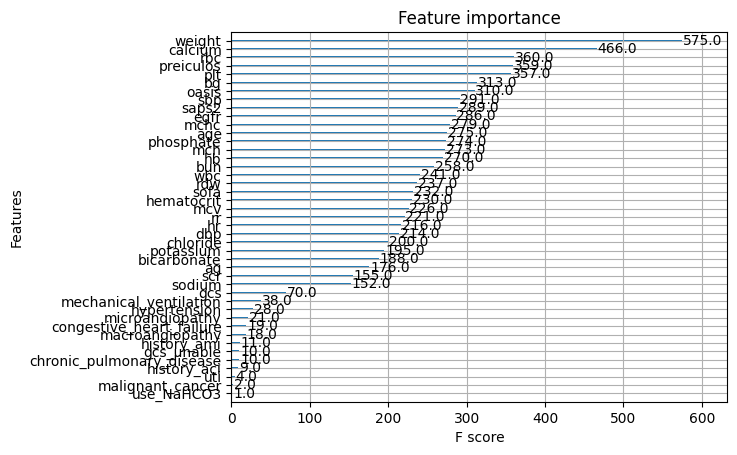

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

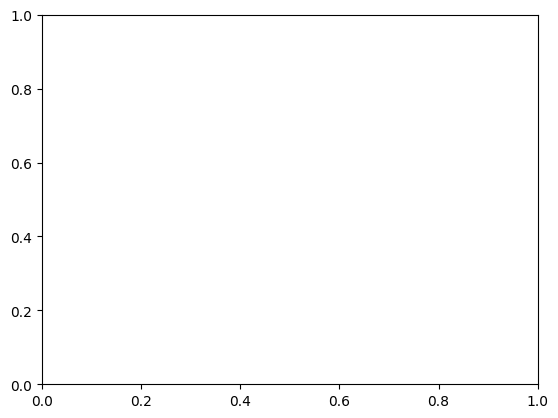

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66659


[1]	validation_0-logloss:0.66429


[2]	validation_0-logloss:0.66225


[3]	validation_0-logloss:0.66043


[4]	validation_0-logloss:0.65837


[5]	validation_0-logloss:0.65615


[6]	validation_0-logloss:0.65383


[7]	validation_0-logloss:0.65142


[8]	validation_0-logloss:0.64923


[9]	validation_0-logloss:0.64751


[10]	validation_0-logloss:0.64514


[11]	validation_0-logloss:0.64295


[12]	validation_0-logloss:0.64086


[13]	validation_0-logloss:0.63902


[14]	validation_0-logloss:0.63688


[15]	validation_0-logloss:0.63429


[16]	validation_0-logloss:0.63214


[17]	validation_0-logloss:0.62990


[18]	validation_0-logloss:0.62854


[19]	validation_0-logloss:0.62700


[20]	validation_0-logloss:0.62518


[21]	validation_0-logloss:0.62341


[22]	validation_0-logloss:0.62128


[23]	validation_0-logloss:0.61995


[24]	validation_0-logloss:0.61844


[25]	validation_0-logloss:0.61661


[26]	validation_0-logloss:0.61461


[27]	validation_0-logloss:0.61273


[28]	validation_0-logloss:0.61098


[29]	validation_0-logloss:0.60939


[30]	validation_0-logloss:0.60831


[31]	validation_0-logloss:0.60698


[32]	validation_0-logloss:0.60559


[33]	validation_0-logloss:0.60434


[34]	validation_0-logloss:0.60261


[35]	validation_0-logloss:0.60136


[36]	validation_0-logloss:0.59982


[37]	validation_0-logloss:0.59793


[38]	validation_0-logloss:0.59623


[39]	validation_0-logloss:0.59448


[40]	validation_0-logloss:0.59315


[41]	validation_0-logloss:0.59168


[42]	validation_0-logloss:0.59004


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation_0-logloss:0.58885


[44]	validation_0-logloss:0.58746


[45]	validation_0-logloss:0.58641


[46]	validation_0-logloss:0.58578


[47]	validation_0-logloss:0.58469


[48]	validation_0-logloss:0.58370


[49]	validation_0-logloss:0.58287


[50]	validation_0-logloss:0.58156


[51]	validation_0-logloss:0.58009


[52]	validation_0-logloss:0.57920


[53]	validation_0-logloss:0.57771


[54]	validation_0-logloss:0.57661


[55]	validation_0-logloss:0.57528


[56]	validation_0-logloss:0.57427


[57]	validation_0-logloss:0.57354


[58]	validation_0-logloss:0.57248


[59]	validation_0-logloss:0.57140


[60]	validation_0-logloss:0.57022


[61]	validation_0-logloss:0.56910


[62]	validation_0-logloss:0.56817

[63]	validation_0-logloss:0.56745


[64]	validation_0-logloss:0.56642


[65]	validation_0-logloss:0.56536


[66]	validation_0-logloss:0.56416


[67]	validation_0-logloss:0.56311


[68]	validation_0-logloss:0.56216


[69]	validation_0-logloss:0.56110


[70]	validation_0-logloss:0.56023


[71]	validation_0-logloss:0.55952


[72]	validation_0-logloss:0.55880


[73]	validation_0-logloss:0.55784


[74]	validation_0-logloss:0.55656


[75]	validation_0-logloss:0.55596


[76]	validation_0-logloss:0.55532


[77]	validation_0-logloss:0.55437


[78]	validation_0-logloss:0.55323


[79]	validation_0-logloss:0.55318


[80]	validation_0-logloss:0.55252


[81]	validation_0-logloss:0.55179


[82]	validation_0-logloss:0.55090


[83]	validation_0-logloss:0.54999


[84]	validation_0-logloss:0.54888


[85]	validation_0-logloss:0.54813

[86]	validation_0-logloss:0.54763


[87]	validation_0-logloss:0.54718


[88]	validation_0-logloss:0.54636


[89]	validation_0-logloss:0.54596


[90]	validation_0-logloss:0.54478


[91]	validation_0-logloss:0.54406


[92]	validation_0-logloss:0.54348


[93]	validation_0-logloss:0.54279


[94]	validation_0-logloss:0.54224


[95]	validation_0-logloss:0.54154


[96]	validation_0-logloss:0.54085


[97]	validation_0-logloss:0.54070


[98]	validation_0-logloss:0.54009


[99]	validation_0-logloss:0.53970


[100]	validation_0-logloss:0.53938


[101]	validation_0-logloss:0.53910


[102]	validation_0-logloss:0.53837


[103]	validation_0-logloss:0.53766


[104]	validation_0-logloss:0.53702


[105]	validation_0-logloss:0.53605


[106]	validation_0-logloss:0.53553


[107]	validation_0-logloss:0.53471


[108]	validation_0-logloss:0.53398


[109]	validation_0-logloss:0.53315


[110]	validation_0-logloss:0.53352


[111]	validation_0-logloss:0.53354


[112]	validation_0-logloss:0.53342


[113]	validation_0-logloss:0.53262


[114]	validation_0-logloss:0.53242

[115]	validation_0-logloss:0.53201


[116]	validation_0-logloss:0.53208


[117]	validation_0-logloss:0.53141


[118]	validation_0-logloss:0.53102


[119]	validation_0-logloss:0.53037


[120]	validation_0-logloss:0.53004


[121]	validation_0-logloss:0.52973


[122]	validation_0-logloss:0.52935


[123]	validation_0-logloss:0.52863


[124]	validation_0-logloss:0.52779


[125]	validation_0-logloss:0.52704


[126]	validation_0-logloss:0.52673


[127]	validation_0-logloss:0.52610


[128]	validation_0-logloss:0.52552


[129]	validation_0-logloss:0.52511


[130]	validation_0-logloss:0.52507

[131]	validation_0-logloss:0.52474

[132]	validation_0-logloss:0.52425


[133]	validation_0-logloss:0.52400


[134]	validation_0-logloss:0.52341


[135]	validation_0-logloss:0.52299


[136]	validation_0-logloss:0.52262


[137]	validation_0-logloss:0.52238


[138]	validation_0-logloss:0.52202


[139]	validation_0-logloss:0.52138


[140]	validation_0-logloss:0.52088


[141]	validation_0-logloss:0.52036


[142]	validation_0-logloss:0.51980


[143]	validation_0-logloss:0.51934


[144]	validation_0-logloss:0.51900


[145]	validation_0-logloss:0.51844


[146]	validation_0-logloss:0.51795


[147]	validation_0-logloss:0.51733


[148]	validation_0-logloss:0.51657


[149]	validation_0-logloss:0.51634


[150]	validation_0-logloss:0.51583


[151]	validation_0-logloss:0.51601


[152]	validation_0-logloss:0.51548


[153]	validation_0-logloss:0.51551


[154]	validation_0-logloss:0.51515


[155]	validation_0-logloss:0.51479


[156]	validation_0-logloss:0.51451


[157]	validation_0-logloss:0.51441


[158]	validation_0-logloss:0.51375


[159]	validation_0-logloss:0.51307


[160]	validation_0-logloss:0.51286


[161]	validation_0-logloss:0.51229


[162]	validation_0-logloss:0.51231


[163]	validation_0-logloss:0.51221


[164]	validation_0-logloss:0.51181

[165]	validation_0-logloss:0.51143


[166]	validation_0-logloss:0.51116


[167]	validation_0-logloss:0.51129


[168]	validation_0-logloss:0.51158


[169]	validation_0-logloss:0.51155


[170]	validation_0-logloss:0.51124


[171]	validation_0-logloss:0.51087


[172]	validation_0-logloss:0.51062


[173]	validation_0-logloss:0.51048


[174]	validation_0-logloss:0.51057


[175]	validation_0-logloss:0.51040


[176]	validation_0-logloss:0.51026


[177]	validation_0-logloss:0.50961


[178]	validation_0-logloss:0.50956


[179]	validation_0-logloss:0.50886

[180]	validation_0-logloss:0.50852


[181]	validation_0-logloss:0.50825


[182]	validation_0-logloss:0.50784


[183]	validation_0-logloss:0.50749


[184]	validation_0-logloss:0.50747


[185]	validation_0-logloss:0.50735


[186]	validation_0-logloss:0.50721


[187]	validation_0-logloss:0.50698


[188]	validation_0-logloss:0.50669


[189]	validation_0-logloss:0.50625


[190]	validation_0-logloss:0.50608


[191]	validation_0-logloss:0.50594


[192]	validation_0-logloss:0.50582


[193]	validation_0-logloss:0.50540


[194]	validation_0-logloss:0.50565


[195]	validation_0-logloss:0.50562


[196]	validation_0-logloss:0.50563


[197]	validation_0-logloss:0.50513


[198]	validation_0-logloss:0.50514


[199]	validation_0-logloss:0.50526


[200]	validation_0-logloss:0.50490


[201]	validation_0-logloss:0.50487


[202]	validation_0-logloss:0.50466


[203]	validation_0-logloss:0.50388


[204]	validation_0-logloss:0.50351


[205]	validation_0-logloss:0.50328


[206]	validation_0-logloss:0.50289

[207]	validation_0-logloss:0.50293


[208]	validation_0-logloss:0.50248


[209]	validation_0-logloss:0.50230


[210]	validation_0-logloss:0.50205


[211]	validation_0-logloss:0.50228

[212]	validation_0-logloss:0.50207


[213]	validation_0-logloss:0.50168


[214]	validation_0-logloss:0.50161


[215]	validation_0-logloss:0.50147


[216]	validation_0-logloss:0.50117


[217]	validation_0-logloss:0.50086


[218]	validation_0-logloss:0.50069


[219]	validation_0-logloss:0.50047


[220]	validation_0-logloss:0.50034


[221]	validation_0-logloss:0.50053


[222]	validation_0-logloss:0.50047


[223]	validation_0-logloss:0.50006


[224]	validation_0-logloss:0.50027


[225]	validation_0-logloss:0.50021


[226]	validation_0-logloss:0.50045


[227]	validation_0-logloss:0.50037


[228]	validation_0-logloss:0.50023


[229]	validation_0-logloss:0.50032


[230]	validation_0-logloss:0.49986


[231]	validation_0-logloss:0.49998


[232]	validation_0-logloss:0.49994


[233]	validation_0-logloss:0.49987


[234]	validation_0-logloss:0.49972


[235]	validation_0-logloss:0.49956


[236]	validation_0-logloss:0.49916


[237]	validation_0-logloss:0.49929


[238]	validation_0-logloss:0.49876


[239]	validation_0-logloss:0.49854


[240]	validation_0-logloss:0.49848

[241]	validation_0-logloss:0.49821


[242]	validation_0-logloss:0.49827


[243]	validation_0-logloss:0.49826


[244]	validation_0-logloss:0.49810


[245]	validation_0-logloss:0.49798


[246]	validation_0-logloss:0.49793


[247]	validation_0-logloss:0.49775


[248]	validation_0-logloss:0.49758


[249]	validation_0-logloss:0.49736


[250]	validation_0-logloss:0.49727


[251]	validation_0-logloss:0.49728


[252]	validation_0-logloss:0.49695


[253]	validation_0-logloss:0.49668


[254]	validation_0-logloss:0.49676


[255]	validation_0-logloss:0.49680


[256]	validation_0-logloss:0.49664


[257]	validation_0-logloss:0.49634


[258]	validation_0-logloss:0.49620


[259]	validation_0-logloss:0.49622


[260]	validation_0-logloss:0.49628

[261]	validation_0-logloss:0.49612


[262]	validation_0-logloss:0.49599


[263]	validation_0-logloss:0.49583


[264]	validation_0-logloss:0.49540


[265]	validation_0-logloss:0.49521


[266]	validation_0-logloss:0.49516

[267]	validation_0-logloss:0.49507


[268]	validation_0-logloss:0.49477


[269]	validation_0-logloss:0.49470


[270]	validation_0-logloss:0.49445


[271]	validation_0-logloss:0.49440


[272]	validation_0-logloss:0.49431


[273]	validation_0-logloss:0.49416


[274]	validation_0-logloss:0.49382


[275]	validation_0-logloss:0.49363


[276]	validation_0-logloss:0.49352


[277]	validation_0-logloss:0.49341


[278]	validation_0-logloss:0.49340


[279]	validation_0-logloss:0.49307


[280]	validation_0-logloss:0.49298


[281]	validation_0-logloss:0.49281


[282]	validation_0-logloss:0.49258


[283]	validation_0-logloss:0.49304


[284]	validation_0-logloss:0.49295


[285]	validation_0-logloss:0.49306


[286]	validation_0-logloss:0.49270


[287]	validation_0-logloss:0.49266


[288]	validation_0-logloss:0.49235

[289]	validation_0-logloss:0.49215

[290]	validation_0-logloss:0.49205


[291]	validation_0-logloss:0.49185

[292]	validation_0-logloss:0.49185


[293]	validation_0-logloss:0.49188


[294]	validation_0-logloss:0.49166


[295]	validation_0-logloss:0.49147


[296]	validation_0-logloss:0.49128


[297]	validation_0-logloss:0.49115


[298]	validation_0-logloss:0.49109


[299]	validation_0-logloss:0.49119


[300]	validation_0-logloss:0.49123


[301]	validation_0-logloss:0.49117


[302]	validation_0-logloss:0.49118


[303]	validation_0-logloss:0.49109


[304]	validation_0-logloss:0.49115


[305]	validation_0-logloss:0.49128


[306]	validation_0-logloss:0.49133

[307]	validation_0-logloss:0.49131


[308]	validation_0-logloss:0.49125


[309]	validation_0-logloss:0.49120


[310]	validation_0-logloss:0.49106


[311]	validation_0-logloss:0.49082


[312]	validation_0-logloss:0.49082


[313]	validation_0-logloss:0.49089


[314]	validation_0-logloss:0.49075


[315]	validation_0-logloss:0.49105


[316]	validation_0-logloss:0.49073


[317]	validation_0-logloss:0.49089


[318]	validation_0-logloss:0.49084


[319]	validation_0-logloss:0.49101


[320]	validation_0-logloss:0.49108


[321]	validation_0-logloss:0.49090


[322]	validation_0-logloss:0.49068


[323]	validation_0-logloss:0.49059


[324]	validation_0-logloss:0.49056


[325]	validation_0-logloss:0.49052


[326]	validation_0-logloss:0.49066


[327]	validation_0-logloss:0.49093


[328]	validation_0-logloss:0.49083


[329]	validation_0-logloss:0.49096


[330]	validation_0-logloss:0.49117


[331]	validation_0-logloss:0.49120


[332]	validation_0-logloss:0.49124


[333]	validation_0-logloss:0.49112


[334]	validation_0-logloss:0.49121


[0]	validation_0-logloss:0.66769


[1]	validation_0-logloss:0.66476


[2]	validation_0-logloss:0.66248


[3]	validation_0-logloss:0.66042


[4]	validation_0-logloss:0.65814


[5]	validation_0-logloss:0.65554


[6]	validation_0-logloss:0.65342


[7]	validation_0-logloss:0.65125


[8]	validation_0-logloss:0.64988


[9]	validation_0-logloss:0.64759


[10]	validation_0-logloss:0.64641


[11]	validation_0-logloss:0.64487


[12]	validation_0-logloss:0.64319


[13]	validation_0-logloss:0.64149


[14]	validation_0-logloss:0.63909


[15]	validation_0-logloss:0.63702


[16]	validation_0-logloss:0.63468


[17]	validation_0-logloss:0.63288


[18]	validation_0-logloss:0.63095


[19]	validation_0-logloss:0.62869


[20]	validation_0-logloss:0.62662


[21]	validation_0-logloss:0.62454


[22]	validation_0-logloss:0.62283


[23]	validation_0-logloss:0.62087


[24]	validation_0-logloss:0.61901


[25]	validation_0-logloss:0.61738


[26]	validation_0-logloss:0.61602


[27]	validation_0-logloss:0.61463


[28]	validation_0-logloss:0.61301


[29]	validation_0-logloss:0.61149


[30]	validation_0-logloss:0.61000


[31]	validation_0-logloss:0.60845


[32]	validation_0-logloss:0.60702


[33]	validation_0-logloss:0.60552


[34]	validation_0-logloss:0.60448


[35]	validation_0-logloss:0.60303


[36]	validation_0-logloss:0.60175


[37]	validation_0-logloss:0.60015


[38]	validation_0-logloss:0.59911


[39]	validation_0-logloss:0.59751


[40]	validation_0-logloss:0.59642


[41]	validation_0-logloss:0.59532


[42]	validation_0-logloss:0.59428


[43]	validation_0-logloss:0.59279


[44]	validation_0-logloss:0.59167


[45]	validation_0-logloss:0.59052


[46]	validation_0-logloss:0.58943


[47]	validation_0-logloss:0.58802


[48]	validation_0-logloss:0.58672


[49]	validation_0-logloss:0.58525


[50]	validation_0-logloss:0.58402


[51]	validation_0-logloss:0.58332


[52]	validation_0-logloss:0.58233


[53]	validation_0-logloss:0.58126


[54]	validation_0-logloss:0.57974


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:32:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation_0-logloss:0.57893


[56]	validation_0-logloss:0.57770

[57]	validation_0-logloss:0.57682


[58]	validation_0-logloss:0.57544


[59]	validation_0-logloss:0.57445


[60]	validation_0-logloss:0.57333


[61]	validation_0-logloss:0.57199


[62]	validation_0-logloss:0.57111


[63]	validation_0-logloss:0.57006


[64]	validation_0-logloss:0.56929


[65]	validation_0-logloss:0.56809


[66]	validation_0-logloss:0.56669


[67]	validation_0-logloss:0.56550


[68]	validation_0-logloss:0.56484

[69]	validation_0-logloss:0.56362


[70]	validation_0-logloss:0.56291


[71]	validation_0-logloss:0.56227


[72]	validation_0-logloss:0.56164


[73]	validation_0-logloss:0.56104


[74]	validation_0-logloss:0.56025

[75]	validation_0-logloss:0.55870


[76]	validation_0-logloss:0.55794


[77]	validation_0-logloss:0.55676


[78]	validation_0-logloss:0.55570


[79]	validation_0-logloss:0.55520


[80]	validation_0-logloss:0.55431


[81]	validation_0-logloss:0.55372


[82]	validation_0-logloss:0.55283


[83]	validation_0-logloss:0.55188


[84]	validation_0-logloss:0.55119


[85]	validation_0-logloss:0.55047


[86]	validation_0-logloss:0.54946


[87]	validation_0-logloss:0.54863


[88]	validation_0-logloss:0.54805


[89]	validation_0-logloss:0.54756


[90]	validation_0-logloss:0.54661


[91]	validation_0-logloss:0.54626


[92]	validation_0-logloss:0.54580


[93]	validation_0-logloss:0.54533


[94]	validation_0-logloss:0.54447


[95]	validation_0-logloss:0.54423


[96]	validation_0-logloss:0.54365


[97]	validation_0-logloss:0.54285

[98]	validation_0-logloss:0.54211


[99]	validation_0-logloss:0.54160


[100]	validation_0-logloss:0.54072

[101]	validation_0-logloss:0.54020

[102]	validation_0-logloss:0.53985


[103]	validation_0-logloss:0.53918


[104]	validation_0-logloss:0.53869


[105]	validation_0-logloss:0.53813


[106]	validation_0-logloss:0.53730


[107]	validation_0-logloss:0.53702


[108]	validation_0-logloss:0.53654


[109]	validation_0-logloss:0.53606


[110]	validation_0-logloss:0.53569


[111]	validation_0-logloss:0.53490


[112]	validation_0-logloss:0.53429


[113]	validation_0-logloss:0.53363

[114]	validation_0-logloss:0.53321


[115]	validation_0-logloss:0.53279


[116]	validation_0-logloss:0.53236


[117]	validation_0-logloss:0.53211


[118]	validation_0-logloss:0.53175


[119]	validation_0-logloss:0.53108


[120]	validation_0-logloss:0.53071


[121]	validation_0-logloss:0.53024


[122]	validation_0-logloss:0.52970


[123]	validation_0-logloss:0.52902


[124]	validation_0-logloss:0.52845


[125]	validation_0-logloss:0.52811


[126]	validation_0-logloss:0.52761


[127]	validation_0-logloss:0.52697


[128]	validation_0-logloss:0.52702


[129]	validation_0-logloss:0.52678


[130]	validation_0-logloss:0.52655


[131]	validation_0-logloss:0.52619


[132]	validation_0-logloss:0.52581


[133]	validation_0-logloss:0.52557


[134]	validation_0-logloss:0.52523


[135]	validation_0-logloss:0.52501


[136]	validation_0-logloss:0.52471


[137]	validation_0-logloss:0.52444


[138]	validation_0-logloss:0.52427

[139]	validation_0-logloss:0.52405


[140]	validation_0-logloss:0.52360


[141]	validation_0-logloss:0.52310


[142]	validation_0-logloss:0.52246


[143]	validation_0-logloss:0.52210


[144]	validation_0-logloss:0.52187


[145]	validation_0-logloss:0.52161


[146]	validation_0-logloss:0.52111


[147]	validation_0-logloss:0.52087


[148]	validation_0-logloss:0.52035


[149]	validation_0-logloss:0.52039


[150]	validation_0-logloss:0.52017


[151]	validation_0-logloss:0.51996


[152]	validation_0-logloss:0.51942


[153]	validation_0-logloss:0.51910


[154]	validation_0-logloss:0.51881


[155]	validation_0-logloss:0.51859


[156]	validation_0-logloss:0.51824


[157]	validation_0-logloss:0.51795


[158]	validation_0-logloss:0.51799


[159]	validation_0-logloss:0.51756


[160]	validation_0-logloss:0.51744


[161]	validation_0-logloss:0.51736


[162]	validation_0-logloss:0.51738


[163]	validation_0-logloss:0.51774


[164]	validation_0-logloss:0.51711


[165]	validation_0-logloss:0.51709


[166]	validation_0-logloss:0.51674

[167]	validation_0-logloss:0.51638

[168]	validation_0-logloss:0.51614

[169]	validation_0-logloss:0.51606


[170]	validation_0-logloss:0.51539

[171]	validation_0-logloss:0.51530


[172]	validation_0-logloss:0.51500


[173]	validation_0-logloss:0.51447


[174]	validation_0-logloss:0.51451


[175]	validation_0-logloss:0.51448


[176]	validation_0-logloss:0.51457


[177]	validation_0-logloss:0.51456


[178]	validation_0-logloss:0.51460


[179]	validation_0-logloss:0.51411


[180]	validation_0-logloss:0.51353


[181]	validation_0-logloss:0.51335


[182]	validation_0-logloss:0.51334


[183]	validation_0-logloss:0.51311


[184]	validation_0-logloss:0.51271


[185]	validation_0-logloss:0.51251


[186]	validation_0-logloss:0.51211

[187]	validation_0-logloss:0.51176


[188]	validation_0-logloss:0.51133


[189]	validation_0-logloss:0.51117


[190]	validation_0-logloss:0.51128


[191]	validation_0-logloss:0.51059


[192]	validation_0-logloss:0.51011


[193]	validation_0-logloss:0.50960


[194]	validation_0-logloss:0.50961


[195]	validation_0-logloss:0.50928


[196]	validation_0-logloss:0.50926


[197]	validation_0-logloss:0.50906


[198]	validation_0-logloss:0.50869


[199]	validation_0-logloss:0.50862


[200]	validation_0-logloss:0.50854


[201]	validation_0-logloss:0.50854


[202]	validation_0-logloss:0.50843


[203]	validation_0-logloss:0.50812


[204]	validation_0-logloss:0.50806


[205]	validation_0-logloss:0.50796


[206]	validation_0-logloss:0.50804


[207]	validation_0-logloss:0.50743


[208]	validation_0-logloss:0.50711


[209]	validation_0-logloss:0.50744


[210]	validation_0-logloss:0.50710


[211]	validation_0-logloss:0.50708


[212]	validation_0-logloss:0.50706


[213]	validation_0-logloss:0.50693


[214]	validation_0-logloss:0.50678


[215]	validation_0-logloss:0.50667


[216]	validation_0-logloss:0.50641


[217]	validation_0-logloss:0.50635


[218]	validation_0-logloss:0.50616

[219]	validation_0-logloss:0.50608


[220]	validation_0-logloss:0.50606


[221]	validation_0-logloss:0.50591


[222]	validation_0-logloss:0.50561


[223]	validation_0-logloss:0.50519


[224]	validation_0-logloss:0.50493


[225]	validation_0-logloss:0.50487


[226]	validation_0-logloss:0.50480


[227]	validation_0-logloss:0.50503


[228]	validation_0-logloss:0.50491


[229]	validation_0-logloss:0.50482


[230]	validation_0-logloss:0.50461


[231]	validation_0-logloss:0.50448


[232]	validation_0-logloss:0.50424


[233]	validation_0-logloss:0.50380


[234]	validation_0-logloss:0.50368


[235]	validation_0-logloss:0.50351


[236]	validation_0-logloss:0.50315


[237]	validation_0-logloss:0.50316


[238]	validation_0-logloss:0.50302


[239]	validation_0-logloss:0.50264


[240]	validation_0-logloss:0.50255


[241]	validation_0-logloss:0.50244


[242]	validation_0-logloss:0.50226


[243]	validation_0-logloss:0.50270


[244]	validation_0-logloss:0.50262


[245]	validation_0-logloss:0.50263


[246]	validation_0-logloss:0.50252


[247]	validation_0-logloss:0.50216


[248]	validation_0-logloss:0.50199


[249]	validation_0-logloss:0.50167


[250]	validation_0-logloss:0.50159


[251]	validation_0-logloss:0.50167


[252]	validation_0-logloss:0.50167


[253]	validation_0-logloss:0.50131


[254]	validation_0-logloss:0.50135


[255]	validation_0-logloss:0.50120


[256]	validation_0-logloss:0.50109


[257]	validation_0-logloss:0.50098


[258]	validation_0-logloss:0.50074


[259]	validation_0-logloss:0.50076


[260]	validation_0-logloss:0.50059


[261]	validation_0-logloss:0.50035


[262]	validation_0-logloss:0.50022


[263]	validation_0-logloss:0.50033


[264]	validation_0-logloss:0.50025


[265]	validation_0-logloss:0.50005


[266]	validation_0-logloss:0.49970

[267]	validation_0-logloss:0.49960


[268]	validation_0-logloss:0.49943


[269]	validation_0-logloss:0.49939


[270]	validation_0-logloss:0.49944


[271]	validation_0-logloss:0.49923


[272]	validation_0-logloss:0.49941


[273]	validation_0-logloss:0.49935


[274]	validation_0-logloss:0.49933


[275]	validation_0-logloss:0.49940


[276]	validation_0-logloss:0.49925


[277]	validation_0-logloss:0.49926


[278]	validation_0-logloss:0.49945


[279]	validation_0-logloss:0.49928


[280]	validation_0-logloss:0.49915


[281]	validation_0-logloss:0.49920


[282]	validation_0-logloss:0.49926


[283]	validation_0-logloss:0.49936


[284]	validation_0-logloss:0.49951


[285]	validation_0-logloss:0.49953


[286]	validation_0-logloss:0.49951


[287]	validation_0-logloss:0.49947


[288]	validation_0-logloss:0.49943


[289]	validation_0-logloss:0.49961

[290]	validation_0-logloss:0.49939


[0]	validation_0-logloss:0.66847


[1]	validation_0-logloss:0.66629


[2]	validation_0-logloss:0.66389


[3]	validation_0-logloss:0.66177


[4]	validation_0-logloss:0.65993


[5]	validation_0-logloss:0.65820


[6]	validation_0-logloss:0.65692


[7]	validation_0-logloss:0.65443


[8]	validation_0-logloss:0.65298


[9]	validation_0-logloss:0.65112


[10]	validation_0-logloss:0.64935


[11]	validation_0-logloss:0.64795


[12]	validation_0-logloss:0.64593


[13]	validation_0-logloss:0.64486


[14]	validation_0-logloss:0.64321


[15]	validation_0-logloss:0.64123


[16]	validation_0-logloss:0.64001


[17]	validation_0-logloss:0.63871


[18]	validation_0-logloss:0.63718


[19]	validation_0-logloss:0.63565


[20]	validation_0-logloss:0.63486


[21]	validation_0-logloss:0.63354


[22]	validation_0-logloss:0.63195


[23]	validation_0-logloss:0.63087


[24]	validation_0-logloss:0.62954


[25]	validation_0-logloss:0.62779


[26]	validation_0-logloss:0.62625


[27]	validation_0-logloss:0.62521


[28]	validation_0-logloss:0.62374


[29]	validation_0-logloss:0.62245


[30]	validation_0-logloss:0.62061


[31]	validation_0-logloss:0.61936


[32]	validation_0-logloss:0.61817


[33]	validation_0-logloss:0.61745


[34]	validation_0-logloss:0.61645


[35]	validation_0-logloss:0.61602


[36]	validation_0-logloss:0.61473


[37]	validation_0-logloss:0.61391


[38]	validation_0-logloss:0.61280


[39]	validation_0-logloss:0.61195


[40]	validation_0-logloss:0.61117


[41]	validation_0-logloss:0.60991


[42]	validation_0-logloss:0.60963


[43]	validation_0-logloss:0.60810


[44]	validation_0-logloss:0.60687


[45]	validation_0-logloss:0.60620


[46]	validation_0-logloss:0.60519


[47]	validation_0-logloss:0.60475


[48]	validation_0-logloss:0.60368


[49]	validation_0-logloss:0.60271


[50]	validation_0-logloss:0.60180


[51]	validation_0-logloss:0.60077


[52]	validation_0-logloss:0.59955


[53]	validation_0-logloss:0.59887


[54]	validation_0-logloss:0.59819


[55]	validation_0-logloss:0.59736


[56]	validation_0-logloss:0.59666


[57]	validation_0-logloss:0.59560


[58]	validation_0-logloss:0.59512


[59]	validation_0-logloss:0.59434


[60]	validation_0-logloss:0.59356


[61]	validation_0-logloss:0.59226


[62]	validation_0-logloss:0.59165


[63]	validation_0-logloss:0.59047


[64]	validation_0-logloss:0.59016


[65]	validation_0-logloss:0.58946


[66]	validation_0-logloss:0.58882


[67]	validation_0-logloss:0.58810


[68]	validation_0-logloss:0.58798


[69]	validation_0-logloss:0.58747


[70]	validation_0-logloss:0.58696


[71]	validation_0-logloss:0.58658


[72]	validation_0-logloss:0.58596


[73]	validation_0-logloss:0.58525


[74]	validation_0-logloss:0.58445


[75]	validation_0-logloss:0.58364


[76]	validation_0-logloss:0.58335


[77]	validation_0-logloss:0.58289


[78]	validation_0-logloss:0.58214


[79]	validation_0-logloss:0.58169


[80]	validation_0-logloss:0.58163


[81]	validation_0-logloss:0.58058


[82]	validation_0-logloss:0.58010


[83]	validation_0-logloss:0.57991


[84]	validation_0-logloss:0.57912


[85]	validation_0-logloss:0.57856


[86]	validation_0-logloss:0.57766


[87]	validation_0-logloss:0.57743


[88]	validation_0-logloss:0.57673


[89]	validation_0-logloss:0.57651


[90]	validation_0-logloss:0.57599


[91]	validation_0-logloss:0.57586


[92]	validation_0-logloss:0.57536


[93]	validation_0-logloss:0.57538


[94]	validation_0-logloss:0.57446


[95]	validation_0-logloss:0.57389


[96]	validation_0-logloss:0.57343


[97]	validation_0-logloss:0.57305


[98]	validation_0-logloss:0.57294


[99]	validation_0-logloss:0.57298


[100]	validation_0-logloss:0.57283


[101]	validation_0-logloss:0.57218


[102]	validation_0-logloss:0.57122


[103]	validation_0-logloss:0.57029


[104]	validation_0-logloss:0.57030


[105]	validation_0-logloss:0.57002


[106]	validation_0-logloss:0.56961


[107]	validation_0-logloss:0.56941


[108]	validation_0-logloss:0.56945


[109]	validation_0-logloss:0.56915


[110]	validation_0-logloss:0.56887


[111]	validation_0-logloss:0.56877


[112]	validation_0-logloss:0.56902


[113]	validation_0-logloss:0.56859


[114]	validation_0-logloss:0.56830


[115]	validation_0-logloss:0.56783


[116]	validation_0-logloss:0.56728


[117]	validation_0-logloss:0.56678


[118]	validation_0-logloss:0.56608


[119]	validation_0-logloss:0.56561


[120]	validation_0-logloss:0.56520


[121]	validation_0-logloss:0.56500


[122]	validation_0-logloss:0.56444


[123]	validation_0-logloss:0.56374


[124]	validation_0-logloss:0.56329


[125]	validation_0-logloss:0.56288


[126]	validation_0-logloss:0.56297


[127]	validation_0-logloss:0.56270


[128]	validation_0-logloss:0.56204


[129]	validation_0-logloss:0.56155


[130]	validation_0-logloss:0.56106


[131]	validation_0-logloss:0.56074


[132]	validation_0-logloss:0.56052


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[133]	validation_0-logloss:0.56033


[134]	validation_0-logloss:0.56007


[135]	validation_0-logloss:0.55979


[136]	validation_0-logloss:0.55941


[137]	validation_0-logloss:0.55899


[138]	validation_0-logloss:0.55860


[139]	validation_0-logloss:0.55785


[140]	validation_0-logloss:0.55736


[141]	validation_0-logloss:0.55739


[142]	validation_0-logloss:0.55691


[143]	validation_0-logloss:0.55647


[144]	validation_0-logloss:0.55639


[145]	validation_0-logloss:0.55633


[146]	validation_0-logloss:0.55601


[147]	validation_0-logloss:0.55638


[148]	validation_0-logloss:0.55608


[149]	validation_0-logloss:0.55592


[150]	validation_0-logloss:0.55565


[151]	validation_0-logloss:0.55546


[152]	validation_0-logloss:0.55519


[153]	validation_0-logloss:0.55475


[154]	validation_0-logloss:0.55457


[155]	validation_0-logloss:0.55409


[156]	validation_0-logloss:0.55373


[157]	validation_0-logloss:0.55369


[158]	validation_0-logloss:0.55345


[159]	validation_0-logloss:0.55325


[160]	validation_0-logloss:0.55343


[161]	validation_0-logloss:0.55291


[162]	validation_0-logloss:0.55255


[163]	validation_0-logloss:0.55212


[164]	validation_0-logloss:0.55193


[165]	validation_0-logloss:0.55205


[166]	validation_0-logloss:0.55192


[167]	validation_0-logloss:0.55141


[168]	validation_0-logloss:0.55151


[169]	validation_0-logloss:0.55128


[170]	validation_0-logloss:0.55120


[171]	validation_0-logloss:0.55084


[172]	validation_0-logloss:0.55063


[173]	validation_0-logloss:0.55055


[174]	validation_0-logloss:0.55042


[175]	validation_0-logloss:0.55033


[176]	validation_0-logloss:0.55061


[177]	validation_0-logloss:0.55068


[178]	validation_0-logloss:0.55068


[179]	validation_0-logloss:0.55095


[180]	validation_0-logloss:0.55093


[181]	validation_0-logloss:0.55061


[182]	validation_0-logloss:0.55078


[183]	validation_0-logloss:0.55048


[184]	validation_0-logloss:0.55024


[185]	validation_0-logloss:0.55015


[186]	validation_0-logloss:0.54980


[187]	validation_0-logloss:0.54973


[188]	validation_0-logloss:0.54961


[189]	validation_0-logloss:0.54946


[190]	validation_0-logloss:0.54952


[191]	validation_0-logloss:0.54949


[192]	validation_0-logloss:0.54923


[193]	validation_0-logloss:0.54923


[194]	validation_0-logloss:0.54900


[195]	validation_0-logloss:0.54882


[196]	validation_0-logloss:0.54874


[197]	validation_0-logloss:0.54888


[198]	validation_0-logloss:0.54901


[199]	validation_0-logloss:0.54884


[200]	validation_0-logloss:0.54898


[201]	validation_0-logloss:0.54897


[202]	validation_0-logloss:0.54899


[203]	validation_0-logloss:0.54911


[204]	validation_0-logloss:0.54883


[205]	validation_0-logloss:0.54900


[0]	validation_0-logloss:0.66773


[1]	validation_0-logloss:0.66571


[2]	validation_0-logloss:0.66284


[3]	validation_0-logloss:0.66059


[4]	validation_0-logloss:0.65846


[5]	validation_0-logloss:0.65640


[6]	validation_0-logloss:0.65414


[7]	validation_0-logloss:0.65160


[8]	validation_0-logloss:0.64995


[9]	validation_0-logloss:0.64829


[10]	validation_0-logloss:0.64635


[11]	validation_0-logloss:0.64494


[12]	validation_0-logloss:0.64316


[13]	validation_0-logloss:0.64071


[14]	validation_0-logloss:0.63936


[15]	validation_0-logloss:0.63700


[16]	validation_0-logloss:0.63527


[17]	validation_0-logloss:0.63303


[18]	validation_0-logloss:0.63127


[19]	validation_0-logloss:0.63032


[20]	validation_0-logloss:0.62836


[21]	validation_0-logloss:0.62681


[22]	validation_0-logloss:0.62463


[23]	validation_0-logloss:0.62309


[24]	validation_0-logloss:0.62139


[25]	validation_0-logloss:0.61942


[26]	validation_0-logloss:0.61779


[27]	validation_0-logloss:0.61622


[28]	validation_0-logloss:0.61462


[29]	validation_0-logloss:0.61282


[30]	validation_0-logloss:0.61124


[31]	validation_0-logloss:0.61001


[32]	validation_0-logloss:0.60878


[33]	validation_0-logloss:0.60769


[34]	validation_0-logloss:0.60633


[35]	validation_0-logloss:0.60542


[36]	validation_0-logloss:0.60437


[37]	validation_0-logloss:0.60319


[38]	validation_0-logloss:0.60247


[39]	validation_0-logloss:0.60165


[40]	validation_0-logloss:0.60051


[41]	validation_0-logloss:0.59917


[42]	validation_0-logloss:0.59816


[43]	validation_0-logloss:0.59753


[44]	validation_0-logloss:0.59673


[45]	validation_0-logloss:0.59580


[46]	validation_0-logloss:0.59449


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:32:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation_0-logloss:0.59308


[48]	validation_0-logloss:0.59190


[49]	validation_0-logloss:0.59081


[50]	validation_0-logloss:0.58981


[51]	validation_0-logloss:0.58887


[52]	validation_0-logloss:0.58817


[53]	validation_0-logloss:0.58713


[54]	validation_0-logloss:0.58620


[55]	validation_0-logloss:0.58534


[56]	validation_0-logloss:0.58417


[57]	validation_0-logloss:0.58294


[58]	validation_0-logloss:0.58216


[59]	validation_0-logloss:0.58133


[60]	validation_0-logloss:0.58009


[61]	validation_0-logloss:0.57911


[62]	validation_0-logloss:0.57838


[63]	validation_0-logloss:0.57773


[64]	validation_0-logloss:0.57693


[65]	validation_0-logloss:0.57588


[66]	validation_0-logloss:0.57493


[67]	validation_0-logloss:0.57438


[68]	validation_0-logloss:0.57337


[69]	validation_0-logloss:0.57304


[70]	validation_0-logloss:0.57185


[71]	validation_0-logloss:0.57111


[72]	validation_0-logloss:0.57062


[73]	validation_0-logloss:0.56958


[74]	validation_0-logloss:0.56869


[75]	validation_0-logloss:0.56794


[76]	validation_0-logloss:0.56717


[77]	validation_0-logloss:0.56688


[78]	validation_0-logloss:0.56569


[79]	validation_0-logloss:0.56514


[80]	validation_0-logloss:0.56417


[81]	validation_0-logloss:0.56377


[82]	validation_0-logloss:0.56283


[83]	validation_0-logloss:0.56205


[84]	validation_0-logloss:0.56134


[85]	validation_0-logloss:0.56085


[86]	validation_0-logloss:0.56017


[87]	validation_0-logloss:0.56004


[88]	validation_0-logloss:0.55881


[89]	validation_0-logloss:0.55832


[90]	validation_0-logloss:0.55780


[91]	validation_0-logloss:0.55750


[92]	validation_0-logloss:0.55703


[93]	validation_0-logloss:0.55630


[94]	validation_0-logloss:0.55530


[95]	validation_0-logloss:0.55466


[96]	validation_0-logloss:0.55401


[97]	validation_0-logloss:0.55329


[98]	validation_0-logloss:0.55291


[99]	validation_0-logloss:0.55241


[100]	validation_0-logloss:0.55230


[101]	validation_0-logloss:0.55140


[102]	validation_0-logloss:0.55062


[103]	validation_0-logloss:0.55036


[104]	validation_0-logloss:0.54951


[105]	validation_0-logloss:0.54895


[106]	validation_0-logloss:0.54877

[107]	validation_0-logloss:0.54834


[108]	validation_0-logloss:0.54757


[109]	validation_0-logloss:0.54729


[110]	validation_0-logloss:0.54683


[111]	validation_0-logloss:0.54650


[112]	validation_0-logloss:0.54594


[113]	validation_0-logloss:0.54552


[114]	validation_0-logloss:0.54511


[115]	validation_0-logloss:0.54470


[116]	validation_0-logloss:0.54457


[117]	validation_0-logloss:0.54391


[118]	validation_0-logloss:0.54356


[119]	validation_0-logloss:0.54284


[120]	validation_0-logloss:0.54228

[121]	validation_0-logloss:0.54192


[122]	validation_0-logloss:0.54127


[123]	validation_0-logloss:0.54075


[124]	validation_0-logloss:0.54072


[125]	validation_0-logloss:0.54041


[126]	validation_0-logloss:0.53981


[127]	validation_0-logloss:0.53912


[128]	validation_0-logloss:0.53872


[129]	validation_0-logloss:0.53896


[130]	validation_0-logloss:0.53829


[131]	validation_0-logloss:0.53825


[132]	validation_0-logloss:0.53796

[133]	validation_0-logloss:0.53754


[134]	validation_0-logloss:0.53779


[135]	validation_0-logloss:0.53746


[136]	validation_0-logloss:0.53710


[137]	validation_0-logloss:0.53670


[138]	validation_0-logloss:0.53637

[139]	validation_0-logloss:0.53603


[140]	validation_0-logloss:0.53579


[141]	validation_0-logloss:0.53570


[142]	validation_0-logloss:0.53536


[143]	validation_0-logloss:0.53540


[144]	validation_0-logloss:0.53546


[145]	validation_0-logloss:0.53481


[146]	validation_0-logloss:0.53448


[147]	validation_0-logloss:0.53427


[148]	validation_0-logloss:0.53414


[149]	validation_0-logloss:0.53382


[150]	validation_0-logloss:0.53398


[151]	validation_0-logloss:0.53372


[152]	validation_0-logloss:0.53325


[153]	validation_0-logloss:0.53283


[154]	validation_0-logloss:0.53255


[155]	validation_0-logloss:0.53209


[156]	validation_0-logloss:0.53169


[157]	validation_0-logloss:0.53156


[158]	validation_0-logloss:0.53080


[159]	validation_0-logloss:0.53019


[160]	validation_0-logloss:0.53030


[161]	validation_0-logloss:0.53002


[162]	validation_0-logloss:0.52992


[163]	validation_0-logloss:0.52981


[164]	validation_0-logloss:0.52937


[165]	validation_0-logloss:0.52948

[166]	validation_0-logloss:0.52910


[167]	validation_0-logloss:0.52884


[168]	validation_0-logloss:0.52909


[169]	validation_0-logloss:0.52905


[170]	validation_0-logloss:0.52853


[171]	validation_0-logloss:0.52830


[172]	validation_0-logloss:0.52827


[173]	validation_0-logloss:0.52784


[174]	validation_0-logloss:0.52796


[175]	validation_0-logloss:0.52783


[176]	validation_0-logloss:0.52763


[177]	validation_0-logloss:0.52748


[178]	validation_0-logloss:0.52729

[179]	validation_0-logloss:0.52675


[180]	validation_0-logloss:0.52631


[181]	validation_0-logloss:0.52605

[182]	validation_0-logloss:0.52606

[183]	validation_0-logloss:0.52570


[184]	validation_0-logloss:0.52561


[185]	validation_0-logloss:0.52537


[186]	validation_0-logloss:0.52509


[187]	validation_0-logloss:0.52482


[188]	validation_0-logloss:0.52479


[189]	validation_0-logloss:0.52410


[190]	validation_0-logloss:0.52387


[191]	validation_0-logloss:0.52384


[192]	validation_0-logloss:0.52342


[193]	validation_0-logloss:0.52303


[194]	validation_0-logloss:0.52283


[195]	validation_0-logloss:0.52220


[196]	validation_0-logloss:0.52194


[197]	validation_0-logloss:0.52175


[198]	validation_0-logloss:0.52164


[199]	validation_0-logloss:0.52128


[200]	validation_0-logloss:0.52140


[201]	validation_0-logloss:0.52128


[202]	validation_0-logloss:0.52098


[203]	validation_0-logloss:0.52102


[204]	validation_0-logloss:0.52086


[205]	validation_0-logloss:0.52093


[206]	validation_0-logloss:0.52081


[207]	validation_0-logloss:0.52079


[208]	validation_0-logloss:0.52083


[209]	validation_0-logloss:0.52098


[210]	validation_0-logloss:0.52080


[211]	validation_0-logloss:0.52074


[212]	validation_0-logloss:0.52060


[213]	validation_0-logloss:0.52103


[214]	validation_0-logloss:0.52077


[215]	validation_0-logloss:0.52044


[216]	validation_0-logloss:0.52048


[217]	validation_0-logloss:0.52044


[218]	validation_0-logloss:0.52049


[219]	validation_0-logloss:0.52046


[220]	validation_0-logloss:0.52059


[221]	validation_0-logloss:0.52048


[222]	validation_0-logloss:0.52061


[223]	validation_0-logloss:0.52059


[224]	validation_0-logloss:0.52074


[0]	validation_0-logloss:0.66758


[1]	validation_0-logloss:0.66499


[2]	validation_0-logloss:0.66255


[3]	validation_0-logloss:0.66066


[4]	validation_0-logloss:0.65857


[5]	validation_0-logloss:0.65682


[6]	validation_0-logloss:0.65506


[7]	validation_0-logloss:0.65386


[8]	validation_0-logloss:0.65238


[9]	validation_0-logloss:0.65060


[10]	validation_0-logloss:0.64869


[11]	validation_0-logloss:0.64726


[12]	validation_0-logloss:0.64503


[13]	validation_0-logloss:0.64308


[14]	validation_0-logloss:0.64143


[15]	validation_0-logloss:0.63985


[16]	validation_0-logloss:0.63831


[17]	validation_0-logloss:0.63671


[18]	validation_0-logloss:0.63469


[19]	validation_0-logloss:0.63353


[20]	validation_0-logloss:0.63215


[21]	validation_0-logloss:0.63015


[22]	validation_0-logloss:0.62856


[23]	validation_0-logloss:0.62695


[24]	validation_0-logloss:0.62598


[25]	validation_0-logloss:0.62422


[26]	validation_0-logloss:0.62260


[27]	validation_0-logloss:0.62087


[28]	validation_0-logloss:0.61930


[29]	validation_0-logloss:0.61787


[30]	validation_0-logloss:0.61699


[31]	validation_0-logloss:0.61535


[32]	validation_0-logloss:0.61375


[33]	validation_0-logloss:0.61216


[34]	validation_0-logloss:0.61057


[35]	validation_0-logloss:0.60953


[36]	validation_0-logloss:0.60827


[37]	validation_0-logloss:0.60692


[38]	validation_0-logloss:0.60588


[39]	validation_0-logloss:0.60478


[40]	validation_0-logloss:0.60373


[41]	validation_0-logloss:0.60245


[42]	validation_0-logloss:0.60086


[43]	validation_0-logloss:0.59980


[44]	validation_0-logloss:0.59884


[45]	validation_0-logloss:0.59809


[46]	validation_0-logloss:0.59667


[47]	validation_0-logloss:0.59564


[48]	validation_0-logloss:0.59491


[49]	validation_0-logloss:0.59404


[50]	validation_0-logloss:0.59318


[51]	validation_0-logloss:0.59210


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:32:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[52]	validation_0-logloss:0.59109


[53]	validation_0-logloss:0.58983


[54]	validation_0-logloss:0.58918


[55]	validation_0-logloss:0.58827


[56]	validation_0-logloss:0.58754


[57]	validation_0-logloss:0.58605


[58]	validation_0-logloss:0.58549


[59]	validation_0-logloss:0.58524


[60]	validation_0-logloss:0.58386


[61]	validation_0-logloss:0.58302


[62]	validation_0-logloss:0.58252


[63]	validation_0-logloss:0.58115


[64]	validation_0-logloss:0.58041


[65]	validation_0-logloss:0.57974


[66]	validation_0-logloss:0.57867


[67]	validation_0-logloss:0.57810

[68]	validation_0-logloss:0.57772


[69]	validation_0-logloss:0.57753


[70]	validation_0-logloss:0.57667


[71]	validation_0-logloss:0.57615


[72]	validation_0-logloss:0.57494


[73]	validation_0-logloss:0.57474


[74]	validation_0-logloss:0.57380


[75]	validation_0-logloss:0.57318


[76]	validation_0-logloss:0.57234


[77]	validation_0-logloss:0.57178


[78]	validation_0-logloss:0.57079


[79]	validation_0-logloss:0.57006


[80]	validation_0-logloss:0.56931


[81]	validation_0-logloss:0.56891


[82]	validation_0-logloss:0.56829


[83]	validation_0-logloss:0.56748


[84]	validation_0-logloss:0.56676


[85]	validation_0-logloss:0.56623


[86]	validation_0-logloss:0.56527


[87]	validation_0-logloss:0.56469


[88]	validation_0-logloss:0.56419


[89]	validation_0-logloss:0.56370


[90]	validation_0-logloss:0.56306


[91]	validation_0-logloss:0.56236


[92]	validation_0-logloss:0.56202


[93]	validation_0-logloss:0.56141


[94]	validation_0-logloss:0.56095


[95]	validation_0-logloss:0.55996


[96]	validation_0-logloss:0.55935


[97]	validation_0-logloss:0.55876


[98]	validation_0-logloss:0.55824


[99]	validation_0-logloss:0.55807


[100]	validation_0-logloss:0.55787


[101]	validation_0-logloss:0.55716


[102]	validation_0-logloss:0.55721


[103]	validation_0-logloss:0.55692


[104]	validation_0-logloss:0.55648


[105]	validation_0-logloss:0.55596


[106]	validation_0-logloss:0.55560


[107]	validation_0-logloss:0.55558


[108]	validation_0-logloss:0.55505


[109]	validation_0-logloss:0.55443


[110]	validation_0-logloss:0.55381


[111]	validation_0-logloss:0.55371


[112]	validation_0-logloss:0.55300


[113]	validation_0-logloss:0.55255


[114]	validation_0-logloss:0.55157


[115]	validation_0-logloss:0.55127

[116]	validation_0-logloss:0.55060


[117]	validation_0-logloss:0.55058


[118]	validation_0-logloss:0.55003


[119]	validation_0-logloss:0.54999


[120]	validation_0-logloss:0.54961


[121]	validation_0-logloss:0.54929


[122]	validation_0-logloss:0.54906


[123]	validation_0-logloss:0.54879

[124]	validation_0-logloss:0.54817


[125]	validation_0-logloss:0.54752


[126]	validation_0-logloss:0.54716


[127]	validation_0-logloss:0.54715


[128]	validation_0-logloss:0.54673


[129]	validation_0-logloss:0.54667


[130]	validation_0-logloss:0.54661


[131]	validation_0-logloss:0.54631


[132]	validation_0-logloss:0.54623


[133]	validation_0-logloss:0.54599


[134]	validation_0-logloss:0.54533


[135]	validation_0-logloss:0.54452


[136]	validation_0-logloss:0.54371


[137]	validation_0-logloss:0.54346

[138]	validation_0-logloss:0.54347


[139]	validation_0-logloss:0.54336


[140]	validation_0-logloss:0.54278

[141]	validation_0-logloss:0.54265


[142]	validation_0-logloss:0.54226


[143]	validation_0-logloss:0.54182


[144]	validation_0-logloss:0.54121


[145]	validation_0-logloss:0.54061


[146]	validation_0-logloss:0.54030


[147]	validation_0-logloss:0.54031


[148]	validation_0-logloss:0.54015


[149]	validation_0-logloss:0.53979


[150]	validation_0-logloss:0.53956


[151]	validation_0-logloss:0.53973


[152]	validation_0-logloss:0.53926


[153]	validation_0-logloss:0.53956


[154]	validation_0-logloss:0.53898


[155]	validation_0-logloss:0.53895


[156]	validation_0-logloss:0.53892


[157]	validation_0-logloss:0.53871


[158]	validation_0-logloss:0.53882


[159]	validation_0-logloss:0.53857


[160]	validation_0-logloss:0.53855


[161]	validation_0-logloss:0.53831

[162]	validation_0-logloss:0.53799


[163]	validation_0-logloss:0.53765


[164]	validation_0-logloss:0.53756


[165]	validation_0-logloss:0.53720

[166]	validation_0-logloss:0.53710


[167]	validation_0-logloss:0.53668


[168]	validation_0-logloss:0.53663

[169]	validation_0-logloss:0.53692


[170]	validation_0-logloss:0.53702


[171]	validation_0-logloss:0.53643


[172]	validation_0-logloss:0.53625


[173]	validation_0-logloss:0.53615


[174]	validation_0-logloss:0.53626


[175]	validation_0-logloss:0.53630


[176]	validation_0-logloss:0.53634


[177]	validation_0-logloss:0.53602


[178]	validation_0-logloss:0.53562


[179]	validation_0-logloss:0.53519


[180]	validation_0-logloss:0.53486


[181]	validation_0-logloss:0.53452


[182]	validation_0-logloss:0.53438


[183]	validation_0-logloss:0.53424


[184]	validation_0-logloss:0.53385


[185]	validation_0-logloss:0.53405


[186]	validation_0-logloss:0.53412


[187]	validation_0-logloss:0.53419


[188]	validation_0-logloss:0.53424


[189]	validation_0-logloss:0.53402


[190]	validation_0-logloss:0.53414

[191]	validation_0-logloss:0.53389


[192]	validation_0-logloss:0.53371


[193]	validation_0-logloss:0.53342


[194]	validation_0-logloss:0.53386


[195]	validation_0-logloss:0.53343


[196]	validation_0-logloss:0.53351


[197]	validation_0-logloss:0.53296


[198]	validation_0-logloss:0.53271


[199]	validation_0-logloss:0.53254


[200]	validation_0-logloss:0.53255


[201]	validation_0-logloss:0.53255


[202]	validation_0-logloss:0.53261


[203]	validation_0-logloss:0.53272


[204]	validation_0-logloss:0.53320


[205]	validation_0-logloss:0.53308


[206]	validation_0-logloss:0.53280


[207]	validation_0-logloss:0.53280


[208]	validation_0-logloss:0.53284


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.8013136037829511
Average Accuracy: 0.7338122835293714
Average Precision: 0.6972046157748429
Average Recall: 0.5802463605823068
